In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
!pip install xgboost==2.0.1

If the `econml` and `wget` python packages are not installed on your machine install them by running the cells below.

In [7]:
!pip install econml

In [8]:
!pip install wget

Importing all the necessary components

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
sys.setrecursionlimit(100000)  # Increase recursion limit
import scipy.special
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

In [10]:
import wget
import os

if os.path.exists('datasets.py'):
    os.remove('datasets.py')
wget.download('https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/T/datasets.py')

if os.path.exists('myxgb.py'):
    os.remove('myxgb.py')
wget.download('https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/T/myxgb.py')

'myxgb.py'

# Setting the High Level Parameters for the Notebook

- The 401k dataset is downloaded from the source by the code and no need to further download anything:
https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.csv

- The welfare dataset is downloaded from the source by the code and no need to further download anything:
https://github.com/gsbDBI/ExperimentData/blob/master/Welfare/ProcessedData/welfarenolabel3.csv.
It is drawn from the analysis in this paper: [Green and Kern, 2012, Modeling Heterogeneous Treatment Effects in Survey Experiments with Bayesian Additive Regression Trees](https://github.com/gsbDBI/ExperimentData/blob/master/Welfare/Green%20and%20Kern%20BART.pdf)

- The Criteo dataset has to be downloaded from here:
https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/input. This file should be downloaded and stored in the same folder as the notebook with the name `criteo-uplift-v2.1.csv`. Warning that this dataset is quite large and the notebook will take longer to execute than the other datasets. If you are using Google Colab, the best way to bring this dataset to your local folder is the following:
    - Go to the Kaggle url above and download the dataset
    - Upload the zipped dataset to a folder in your google drive e.g. `path-to-zip/criteo-uplift-v2.1.csv.zip`
    - Then run the following commands on colab, which will mount your google drive and will unzip the dataset from the drive to the current folder on the local colab machine
    ```python
    from google.colab import drive
    drive.mount('/content/drive')
    
    !unzip -q '/content/drive/My Drive/path-to-zip/criteo-uplift-v2.1.csv.zip' -d .
    ```

In [11]:
dataset = 'welfare'

In [12]:
if dataset == '401k':
    verbose = 0  # verbosity of auto-ml
    n_splits = 5  # cross-fitting and cross-validation splits
    cfit = False
    data = '401k'  # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'charity'}
    plot = True  # whether to plot results
    # feature to use as x axis in plotting, e.g. for criteo 'f1', for 401k 'inc', for welfare 'polviews'
    xfeat = 'inc'
    # Formula for the BLP of CATE regression.
    blp_formula = 'np.log(inc)'  # e.g. 'f1' for criteo, np.log(inc)' for 401k, 'C(polviews)' for the welfare case.
    blp_formula_short = 'log(inc)'
    blp_formula2 = 'np.log(inc) + np.power(np.log(inc), 2) + np.power(np.log(inc), 3) + np.power(np.log(inc), 4)'
    blp_formula2_short = 'poly(log(inc), 4)'
    control_feats = 'all'  # list of subset of features to be used as confounders or the string 'all' for everything
    # list of subset of control features to be used for CATE model or the string 'all' for all controls
    hetero_feats = 'all'
    cov_clip = .01  # clipping of treatment variance p(x)*(1-p(x)), whenever used in inverse propensities
    binary_y = False
    random_seed = 1

    # cost of treatment when performing optimal policy learning, can also be viewed as "threshold for treatment"
    treatment_cost = 4000

    # For semi-synthetic data generation
    semi_synth = False  # Whether true outcome y should be replaced by a fake outcome from a known CEF
    simple_synth = True  # Whether the true CEF of the fake y should be simple or fitted from data
    max_depth = 2  # max depth of random forest during for semi-synthetic model fitting
    scale = .2  # magnitude of noise in semi-synthetic data

In [13]:
if dataset == 'criteo':
    verbose = 0  # verbosity of auto-ml
    # cross-fitting and cross-validation splits; increase to 5 for better statistical performance
    # albeit notebook will take much longer to execute
    n_splits = 2
    cfit = False
    data = 'criteo'  # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'charity'}
    plot = True  # whether to plot results
    # feature to use as x axis in plotting, e.g. for criteo 'f1', for 401k 'inc', for welfare 'polviews'
    xfeat = 'f3'
    control_feats = 'all'  # list of subset of features to be used as confounders or the string 'all' for everything
    # list of subset of control features to be used for CATE model or the string 'all' for all controls
    hetero_feats = 'all'
    cov_clip = .01  # clipping of treatment variance p(x)*(1-p(x)), whenever used in inverse propensities
    binary_y = True
    random_seed = 1
    # Formula for the BLP of CATE regression.
    blp_formula = 'f3'  # e.g. 'f1' for criteo, np.log(inc)' for 401k, 'C(polviews)' for the welfare case.
    blp_formula_short = 'f3'
    blp_formula2 = 'np.power(f3, 2)'
    blp_formula2_short = 'poly(f3, 2)'
    # cost of treatment when performing optimal policy learning, can also be viewed as "threshold for treatment"
    treatment_cost = 0.04

    # For semi-synthetic data generation
    semi_synth = False  # Whether true outcome y should be replaced by a fake outcome from a known CEF
    simple_synth = True  # Whether the true CEF of the fake y should be simple or fitted from data
    max_depth = 2  # max depth of random forest during for semi-synthetic model fitting
    scale = .2  # magnitude of noise in semi-synthetic data

In [14]:
if dataset == 'welfare':
    verbose = 0  # verbosity of auto-ml
    n_splits = 5  # cross-fitting and cross-validation splits
    cfit = True
    data = 'welfare'  # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'star'}
    plot = True  # whether to plot results
    # feature to use as x axis in plotting, e.g. for criteo 'f1', for 401k 'inc', for welfare 'polviews'
    xfeat = 'polviews'
    # Formula for the BLP of CATE regression.
    blp_formula = 'C(polviews)'  # e.g. 'f1' for criteo, np.log(inc)' for 401k, 'C(polviews)' for the welfare case.
    blp_formula_short = 'C(polviews)'
    blp_formula2 = 'polviews'
    blp_formula2_short = 'polviews'
    control_feats = 'all'  # list of subset of features to be used as confounders or the string 'all' for everything
    # list of subset of control features to be used for CATE model or the string 'all' for all controls
    hetero_feats = 'all'
    cov_clip = .01  # clipping of treatment variance p(x)*(1-p(x)), whenever used in inverse propensities
    binary_y = True
    random_seed = 1

    # cost of treatment when performing optimal policy learning, can also be viewed as "threshold for treatment"
    treatment_cost = -.3

    # For semi-synthetic data generation
    semi_synth = False  # Whether true outcome y should be replaced by a fake outcome from a known CEF
    simple_synth = True  # Whether the true CEF of the fake y should be simple or fitted from data
    max_depth = 2  # max depth of random forest during for semi-synthetic model fitting
    scale = .2  # magnitude of noise in semi-synthetic data

In [15]:
def simple_true_cef(D, X):  # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

# Constructing the Dataset

In [16]:
from datasets import fetch_data_generator

get_data, abtest, true_cef, true_cate = fetch_data_generator(data=data, semi_synth=semi_synth,
                                                             simple_synth=simple_synth,
                                                             scale=scale, true_f=simple_true_cef,
                                                             max_depth=max_depth)
X, D, y, groups = get_data()

In [17]:
if semi_synth:
    true_ate = np.mean(true_cate(X))
    print(f'True ATE: {true_ate}')

In [18]:
def rmse(cate, preds):
    return np.sqrt(np.mean((cate - preds)**2))

# Data Analysis

We now have our data $X$, $D$, $y$, of controls, treatments and outcomes. In some datasets, we also have "groups", also known as "clusters". These are group ids, that define a group of samples that are believed to be correlated through unobesrved factors. For instance, in randomized experiments when a whole class is being treated and we have data at the student level, the students in a class constitute a cluster, as their outcome variables are most probably correlated. In such settings, it is helpful to account for the cluster correlations when calculating confidence intervals and when performing sample splitting for either cross-validation or for nuisance estimation. This notebook will not deal with such group clusters. A more tailored analysis is required.

We will be assuming throughout that conditional ignorability is satisfied if we control for all the variables $X$, i.e. the potential outcomes $Y(1), Y(0)$ satisfy
\begin{align}
Y(1), Y(0) ~\perp\hspace{-1em}\perp~D \mid X
\end{align}
Equivalently, we assume that the DAG the corresponds to our setting satisfies that $X$ is a valid adjustment set between $D$ and $Y$, i.e. it blocks all backdoor paths in the DAG.

In [19]:
X.describe()

,hrs1,income,rincome,age,polviews,educ,earnrs,sibs,childs,occ80,...,reg16,family16,parborn,maeduc,degree,hompop,babies,preteen,teens,adults
count,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,...,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000
mean,42.260324,11.305183,10.223367,40.573952,4.083443,14.026497,1.745177,3.426823,1.569613,332.056016,...,4.417758,1.824669,0.886263,11.745874,1.758736,2.645619,0.227628,0.303479,0.216782,1.893004
std,14.018162,1.635527,2.744435,12.179377,1.376485,2.722665,0.830837,2.918114,1.482378,242.739687,...,2.619726,1.662529,2.418884,3.313779,1.177910,1.399372,0.546265,0.656729,0.527373,0.774679
min,0.000000,1.000000,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,38.000000,12.000000,9.000000,31.000000,3.000000,12.000000,1.000000,2.000000,0.000000,156.000000,...,2.000000,1.000000,0.000000,11.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000
50%,40.000000,12.000000,12.000000,40.000000,4.000000,14.000000,2.000000,3.000000,2.000000,305.000000,...,4.000000,1.000000,0.000000,12.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000
75%,50.000000,12.000000,12.000000,49.000000,5.000000,16.000000,2.000000,4.000000,2.000000,458.000000,...,6.500000,1.000000,0.000000,13.000000,3.000000,4.000000,0.000000,0.000000,0.000000,2.000000
max,89.000000,12.000000,12.000000,88.000000,7.000000,20.000000,8.000000,37.000000,8.000000,889.000000,...,9.000000,8.000000,8.000000,20.000000,4.000000,11.000000,4.000000,5.000000,4.000000,8.000000


In [20]:
if control_feats != 'all':
    X = X[control_feats]
    print(X.describe())

In [21]:
X = X - X.mean(axis=0)

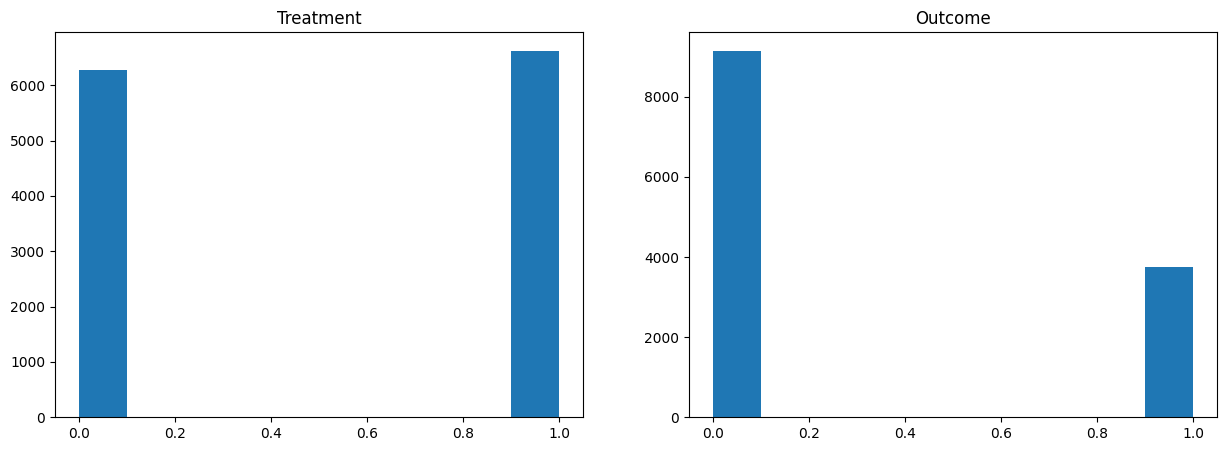

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(D)
plt.title('Treatment')
plt.subplot(1, 2, 2)
plt.hist(y)
plt.title('Outcome')
plt.show()

In [23]:
# simple two means estimate which would be wrong unless an randomized trial
OLS(y, np.hstack([np.ones((D.shape[0], 1)), D.reshape(-1, 1)])).fit(cov_type='HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     2476.
Date:                Wed, 09 Apr 2025   Prob (F-statistic):               0.00
Time:                        00:08:44   Log-Likelihood:                -6969.7
No. Observations:               12907   AIC:                         1.394e+04
Df Residuals:                   12905   BIC:                         1.396e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4798      0.006     76.111      0.000       0.467       0.492
x1            -0.3681      0.007    -49.761      0.000      -0.383      -0.354
==============================================================================
Omnibus:                     1655.598   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1148.663
Skew:                           0.621   Prob(JB):                    3.72e-250
Kurtosis:                       2.230   Cond. No.                         2.65
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

# Split Train and Validation and Test

The training data will be used to fit the various CATE models. The validation data will be used for scoring and selection of the best CATE model or best ensemble of CATE models. The test data will be used for testing and evaluation of the performance of the best chosen model.

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

DX = np.column_stack((D, X))
labels = np.column_stack((D, y)) if binary_y else D
train, val = next(StratifiedShuffleSplit(n_splits=2, train_size=.6,
                                         random_state=random_seed).split(DX, labels))
X, Xval, D, Dval, y, yval = X.iloc[train], X.iloc[val], D[train], D[val], y[train], y[val]

DXval = np.column_stack((Dval, Xval))
labels_val = np.column_stack((Dval, yval)) if binary_y else Dval
val, test = next(StratifiedShuffleSplit(n_splits=2, train_size=.6,
                                        random_state=random_seed).split(DXval, labels_val))
Xval, Xtest, Dval, Dtest, yval, ytest = Xval.iloc[val], Xval.iloc[test], Dval[val], Dval[test], yval[val], yval[test]

# Nuisance Cross-Fitted Estimation and Prediction

We will estimate regression models for each of the nuisance functions that arise in CATE learning approaches. The five models correspond to the following five predictive problems:
\begin{align}
\text{model_y} ~\rightarrow~& q(x) := E[Y\mid X=x]\\
\text{model_t} ~\rightarrow~& p(x) := E[D\mid X=x] = \Pr(D=1\mid X=x)\\
\text{model_reg_zero} ~\rightarrow~& g_0(x) := E[Y\mid D=0, X=x]\\
\text{model_reg_one} ~\rightarrow~& g_1(x) := E[Y\mid D=1, X=x]\\
\end{align}
We will use gradient boosting regression with early stopping for each of these models.

For each of the nuisance models we perform cross-fitting to get out-of-fold predictions from each of these nuisance models. At the end of this process, we will have for each sample $i$, the following out-of-fold nuisance values:
\begin{align}
\text{reg_preds_t} \rightarrow~& \hat{g}_0(X_i) (1 - D_i) + \hat{g}_1(X_i) D_i &
\text{reg_one_preds_t} \rightarrow~& \hat{g}_1(X_i) &
\text{reg_zero_preds_t} \rightarrow~& \hat{g}_0(X_i)\\
\text{res_preds} \rightarrow~& \hat{q}(X_i) &
\text{prop_preds} \rightarrow~& \hat{p}(X_i)
\end{align}

In [25]:
from myxgb import xgb_reg, xgb_clf, xgb_wreg, RegWrapper


def auto_reg():
    return xgb_reg(random_seed)


# Disclaimer: The remainder of the code assumes that the `auto_clf` model returns
# the probability of class 1, when one calls auto_clf().predict(X)
# and not the 0/1 classification. This is what the xgb_clf class does.
def auto_clf():
    return RegWrapper(xgb_clf(random_seed))


def auto_weighted_reg():
    return xgb_wreg(random_seed)


modely = auto_clf if binary_y else auto_reg

In [26]:
if cfit:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    stratification_label = 2 * D + y if binary_y else D
    splits = list(cv.split(X, stratification_label))
else:
    splits = [(np.arange(X.shape[0]), np.arange(X.shape[0]))]

n = X.shape[0]
reg_preds = np.zeros(n)
reg_zero_preds = np.zeros(n)
reg_one_preds = np.zeros(n)
reg_preds_t = np.zeros(n)
reg_zero_preds_t = np.zeros(n)
reg_one_preds_t = np.zeros(n)

DX = np.column_stack((D, X))
for train, test in splits:
    reg = modely().fit(DX[train], y[train])
    reg_preds[test] = reg.predict(DX[test])
    reg_one_preds[test] = reg.predict(np.column_stack([np.ones(len(test)), X.iloc[test]]))
    reg_zero_preds[test] = reg.predict(np.column_stack([np.zeros(len(test)), X.iloc[test]]))

    reg_zero = modely().fit(X.iloc[train][D[train] == 0], y[train][D[train] == 0])
    reg_one = modely().fit(X.iloc[train][D[train] == 1], y[train][D[train] == 1])
    reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test])
    reg_one_preds_t[test] = reg_one.predict(X.iloc[test])
    reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D[test]) + reg_one_preds_t[test] * D[test]

res_preds = cross_val_predict(modely(), X, y, cv=splits)
prop_preds = cross_val_predict(auto_clf(), X, D, cv=splits)

# Evaluating Nuisance Model Performance

We now also evaluate the performance of the selected models in terms of R^2

In [27]:
def r2score(y, ypred):
    return 1 - np.mean((y - ypred)**2) / np.var(y)

In [28]:
print(f"R^2 of model for (y ~ X): {r2score(y, res_preds):.4f}")
print(f"R^2 of model for (D ~ X): {r2score(D, prop_preds):.4f}")
print(f"R^2 of two-learner model for (y ~ X | D==0): {r2score(y[D == 0], reg_zero_preds_t[D == 0]):.4f}")
print(f"R^2 of two-learner model for (y ~ X | D==1): {r2score(y[D == 1], reg_one_preds_t[D == 1]):.4f}")
print(f"R^2 of two-learner model for (y ~ D, X): {r2score(y, reg_preds_t):.4f}")
print(f"R^2 of single-learner model for (y ~ D, X): {r2score(y, reg_preds):.4f}")

R^2 of model for (y ~ X): 0.0456
R^2 of model for (D ~ X): -0.0002
R^2 of two-learner model for (y ~ X | D==0): 0.0707
R^2 of two-learner model for (y ~ X | D==1): 0.0355
R^2 of two-learner model for (y ~ D, X): 0.2145
R^2 of single-learner model for (y ~ D, X): 0.2155


# Doubly-Robust ATE Estimation

Using the doubly robust method. In particular, we construct the doubly robust variables
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) := \hat{g}_1(X_i) - \hat{g}_0(X_i) + (Y_i - \hat{g}_{D_i}(X_i))\frac{D_i - \hat{p}(X_i)}{\hat{p}(X_i) (1-\hat{p}(X_i))}
\end{align}
and then we estimate:
\begin{align}
ATE = E_n\left[Y^{DR}(\hat{g},\hat{p})\right]
\end{align}
This should be more efficient in the worst-case and should be returning a consistent estimate of the ATE even beyond RCTs and will also correctly account for any imbalances or violations of the randomization assumption in an RCT.

In [29]:
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y - reg_preds_t) * (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), cov_clip, np.inf)

OLS(dr_preds, np.ones((len(dr_preds), 1))).fit(cov_type='HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 09 Apr 2025   Prob (F-statistic):                nan
Time:                        00:09:10   Log-Likelihood:                -9428.4
No. Observations:                7744   AIC:                         1.886e+04
Df Residuals:                    7743   BIC:                         1.887e+04
Df Model:                           0                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3656      0.009    -39.347      0.000      -0.384      -0.347
==============================================================================
Omnibus:                      907.837   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              416.585
Skew:                           0.393   Prob(JB):                     3.47e-91
Kurtosis:                       2.179   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [30]:
from statsmodels.formula.api import ols
df = X.copy()
df['dr'] = dr_preds
lr = ols('dr ~ ' + blp_formula, df).fit(cov_type='HC1')
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     dr   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.285
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           8.88e-08
Time:                        00:09:10   Log-Likelihood:                -9408.0
No. Observations:                7744   AIC:                         1.883e+04
Df Residuals:                    7737   BIC:                         1.888e+04
Df Model:                           6                                         
Covariance Type:                  HC1                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.2368      0.054     -4.377      0.000      -0.343      -0.131
C(polviews)[T.-2.083443092895328]      -0.0319      0.059     -0.537      0.591      -0.148       0.084
C(polviews)[T.-1.0834430928953278]     -0.0511      0.059     -0.865      0.387      -0.167       0.065
C(polviews)[T.-0.08344309289532781]    -0.1540      0.056     -2.739      0.006      -0.264      -0.044
C(polviews)[T.0.9165569071046722]      -0.1826      0.059     -3.102      0.002      -0.298      -0.067
C(polviews)[T.1.9165569071046722]      -0.1668      0.060     -2.788      0.005      -0.284      -0.050
C(polviews)[T.2.916556907104672]       -0.2045      0.083     -2.476      0.013      -0.366      -0.043
==============================================================================
Omnibus:                      692.834   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              396.700
Skew:                           0.414   Prob(JB):                     7.20e-87
Kurtosis:                       2.262   Cond. No.                         18.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [31]:
grid = np.unique(np.percentile(X[xfeat], np.arange(0, 102, 2)))
Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                   columns=X.columns)
Xpd[xfeat] = grid
pred_df = lr.get_prediction(Xpd).summary_frame(alpha=.1)

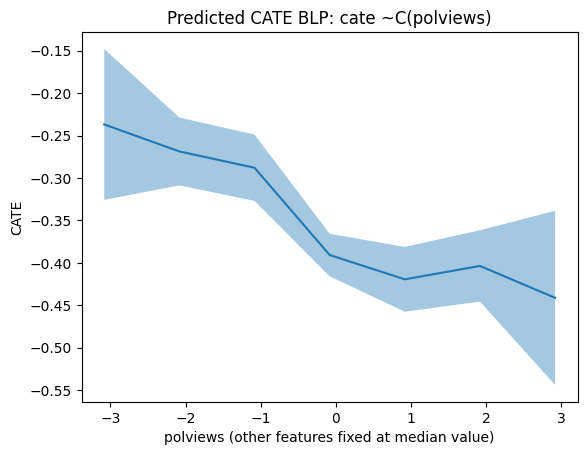

In [32]:
plt.plot(Xpd[xfeat], pred_df['mean'])
plt.fill_between(Xpd[xfeat], pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], alpha=.4)
plt.xlabel(xfeat + ' (other features fixed at median value)')
plt.title('Predicted CATE BLP: cate ~' + blp_formula)
plt.ylabel('CATE')
plt.show()

In [33]:
from statsmodels.formula.api import ols
df = X.copy()
df['dr'] = dr_preds
lr = ols('dr ~ ' + blp_formula2, df).fit(cov_type='HC1')

In [34]:
grid = np.unique(np.percentile(X[xfeat], np.arange(0, 102, 2)))
Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                   columns=X.columns)
Xpd[xfeat] = grid
pred_df2 = lr.get_prediction(Xpd).summary_frame(alpha=.1)

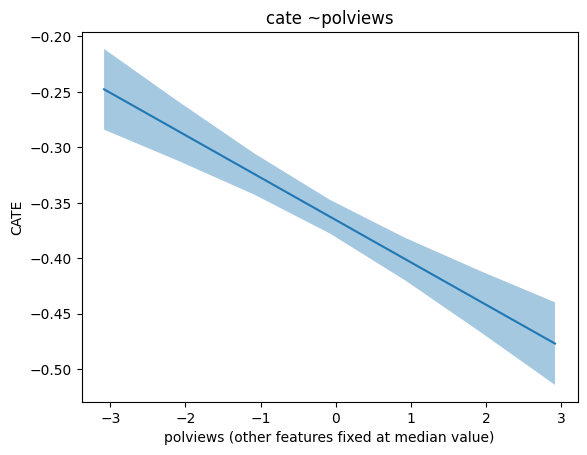

In [35]:
plt.plot(Xpd[xfeat], pred_df2['mean'])
plt.fill_between(Xpd[xfeat], pred_df2['mean_ci_lower'], pred_df2['mean_ci_upper'], alpha=.4)
plt.xlabel(xfeat + ' (other features fixed at median value)')
plt.ylabel('CATE')
plt.title('cate ~' + blp_formula2)
plt.show()

# CATE Model Estimation with Meta-Learners

We specify which indices of the X variables we want to use for heterogeneity. Let's denote these subset of variables with $Z$

In [36]:
if hetero_feats == 'all':
    hetero_feats = X.columns
Z, Zval, Ztest = X[hetero_feats], Xval[hetero_feats], Xtest[hetero_feats]

We specify a generic automl approach for training the final CATE model

### Single Learner (S-Learner)

The S-Learner simply trains a model to predict:
\begin{align}
\hat{g}(1, X_i) - \hat{g}(0, X_i) \sim Z_i
\end{align}

In [37]:
# slearner
slearner = auto_reg().fit(Z, reg_one_preds - reg_zero_preds)
slearner_cates = slearner.predict(Z)

### Two Learner (T-Learner)

The T-Learner simply trains a model to predict:
\begin{align}
\hat{g}_1(X_i) - \hat{g}_0(X_i) \sim Z_i
\end{align}

In [38]:
# tlearner
tlearner = auto_reg().fit(Z, reg_one_preds_t - reg_zero_preds_t)
tlearner_cates = tlearner.predict(Z)

### Cross Learner (X-Learner)

The X-Learner simply trains a two treatment effect models using all the variables $X$:
\begin{align}
\hat{\tau}_1: Y_i - \hat{g}_0(X_i) \sim X_i \\
\hat{\tau}_0: \hat{g}_1(X_i) - Y_i \sim X_i
\end{align}
And then for each target sample $X_i$ we select a mixture based on the propensity.
If $D=1$ is more probable, then we use more heavily $\hat{\tau}_0$, since that uses the model $\hat{g}_1$ which was trained on more data similar to $X_i$ (as indicated by the propensity). Similarly, if $D=0$ is more probably we put more weight on $\hat{\tau}_1$.
\begin{align}
\hat{\tau}(X_i) = \hat{p}(X_i) \hat{\tau}_0(X_i) + (1 - \hat{p}(X_i)) \hat{\tau}_1(X_i)
\tag{xtarget}
\end{align}
Finally, to learn a CATE model that only depends on $Z$, we predict the CATEs $\hat{\tau}$ from $Z$:
\begin{align}
\hat{\tau}(X_i) \sim Z_i
\end{align}

In [39]:
# xlearner
tau1_preds = y[D == 1] - reg_zero_preds_t[D == 1]
tau0_preds = reg_one_preds_t[D == 0] - y[D == 0]
tau1 = auto_reg().fit(X[D == 1], tau1_preds)
tau0 = auto_reg().fit(X[D == 0], tau0_preds)
xtarget = prop_preds * tau0.predict(X) + (1 - prop_preds) * tau1.predict(X)
xlearner = auto_reg().fit(Z, xtarget)
xlearner_cates = xlearner.predict(Z)

### Doubly Robust Learner (DR-Learner)

The DR-Learner (in particular, the variant based on the T-Learner) adds a de-biasing correction to the T-Learner using the propensity. In particular, we construct the doubly robust variables
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) := \hat{g}_1(X_i) - \hat{g}_0(X_i) + (Y_i - \hat{g}_{D_i}(X_i))\frac{D_i - \hat{p}(X_i)}{\hat{p}(X_i) (1-\hat{p}(X_i))}
\end{align}
and then we train a CATE model by predicting these variables from $Z_i$:
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) \sim Z_i
\end{align}
For stability we clip the co-variance that appears in the denominator at some value $c$ bounded away from zero, i.e.
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) := \hat{g}_1(X_i) - \hat{g}_0(X_i) + (Y_i - \hat{g}_{D_i}(X_i))\frac{D_i - \hat{p}(X_i)}{\min\{c, \hat{p}(X_i) (1-\hat{p}(X_i))\}}
\tag{dr_preds}
\end{align}

In [40]:
# drlearner
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y - reg_preds_t) * (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), cov_clip, np.inf)
drlearner = auto_reg().fit(Z, dr_preds)
drlearner_cates = drlearner.predict(Z)

### Residual Learner (R-Learner)

The R-Learner uses the fact that if the true CATE model
$$\theta(X)=E[Y(1)-Y(0)\mid X]$$
only depends on the subset of variables $Z$, then we can write:
\begin{align}
Y =~& \tau(Z) D + b(X) + \epsilon, & E[\epsilon\mid D, X]=~& 0
\end{align}
This then implies that we can also write:
\begin{align}
Y - E[Y\mid X] =~& \tau(Z) (D - E[D|X]) + \epsilon, & E[\epsilon\mid D, X]=~& 0
\end{align}
Hence, if we define the residual outcome and the residual treatment,
\begin{align}
\tilde{Y} :=~& Y - E[Y\mid X] \tag{yres}\\
\tilde{D} :=~& D - E[D\mid X] \tag{Dres}
\end{align}
then we have:
\begin{align}
\tilde{Y} =~& \tau(Z) \tilde{D} + \epsilon, & E[\epsilon\mid D, X]=~& 0
\end{align}
Thus we can estimate the CATE by predicting $\tilde{Y}$ from $\tilde{D}, Z$ with a separable model of the form $\tau(Z) \tilde{D}$. This also implies that $\tau$ is the minimizer of the square loss:
\begin{align}
E\left[ \left(\tilde{Y} - \tau(Z) \tilde{D}\right)^2 \right]
\end{align}
This loss can also be re-written as a sample-weighted regression loss:
\begin{align}
E\left[ \tilde{D}^2 \left(\tilde{Y}/\tilde{D} - \tau(Z) \right)^2 \right]
\end{align}
We are predicting $\tilde{Y}/\tilde{D}$ form $Z$, using sample weights $\tilde{D}^2$.

If the true CATE $\theta(X)$ did not only depend on $Z$, but on the bigger set of covariates $X$, then this method estimates the best projection of the CATE $\theta(X)$ on the space of functions of $Z$, albeit, in a weighted manner, weighted by the variance of the treatment. More formally, the method estimates the minimizer of the following loss:
\begin{align}
\min_{\tau} E\left[\left(\theta(X) - \tau(Z)\right)^2 \, \text{Var}(D\mid X)\right]
\end{align}

In [41]:
# rlearner
yres = y - res_preds
Dres = D - prop_preds
Dres = np.clip(Dres, 1e-6, np.inf) * (Dres >= 0) + np.clip(Dres, -np.inf, -1e-6) * (Dres < 0)

rlearner = auto_weighted_reg().fit(Z.values, yres / Dres, sample_weight=Dres**2)

rlearner_cates = rlearner.predict(Z)

## Constant Effect DR-Learner

We also add a heavily regularized CATE model that predicts the ATE using the doubly robust pseudo outcomes.

In [42]:
drlearner_const = make_pipeline(PolynomialFeatures(degree=0, include_bias=True),
                                LinearRegression(fit_intercept=False))
drlearner_const.fit(Z, dr_preds)
drlearner_const_cates = drlearner_const.predict(Z)

# Interpretability

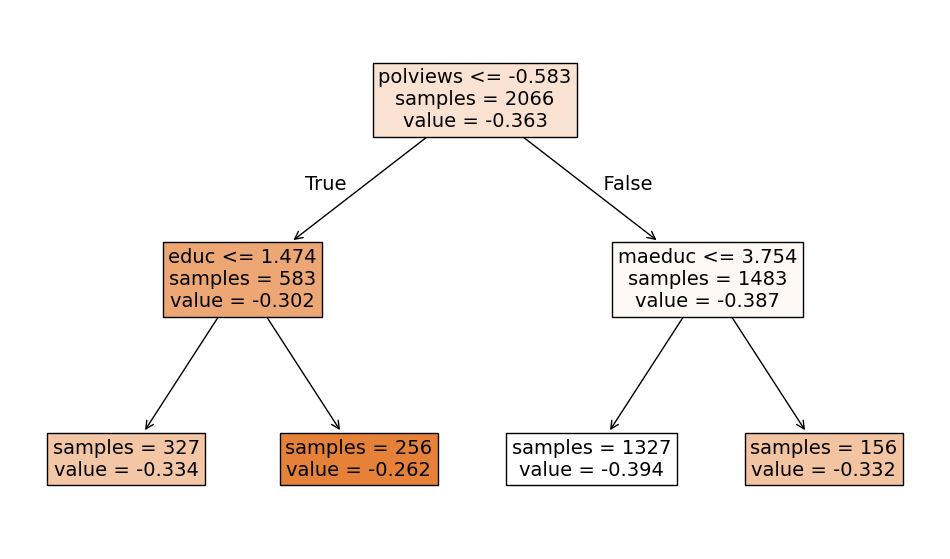

In [43]:
plt.figure(figsize=(12, 7))
tree = DecisionTreeRegressor(max_depth=2, min_samples_leaf=100,
                             min_impurity_decrease=.0001, random_state=random_seed)
tree.fit(Ztest, drlearner.predict(Ztest))
plot_tree(tree, filled=True, feature_names=list(Ztest.columns), fontsize=14, impurity=False)
plt.savefig(f'{data}-distill-tree-cate-dr.png', dpi=600)
plt.show()

In [44]:
import shap

subsample = np.random.choice(Z.shape[0], min(10000, Z.shape[0]), replace=False)
explainer = shap.TreeExplainer(drlearner)
shap_values = explainer.shap_values(Z.iloc[subsample])

[00:09:21] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


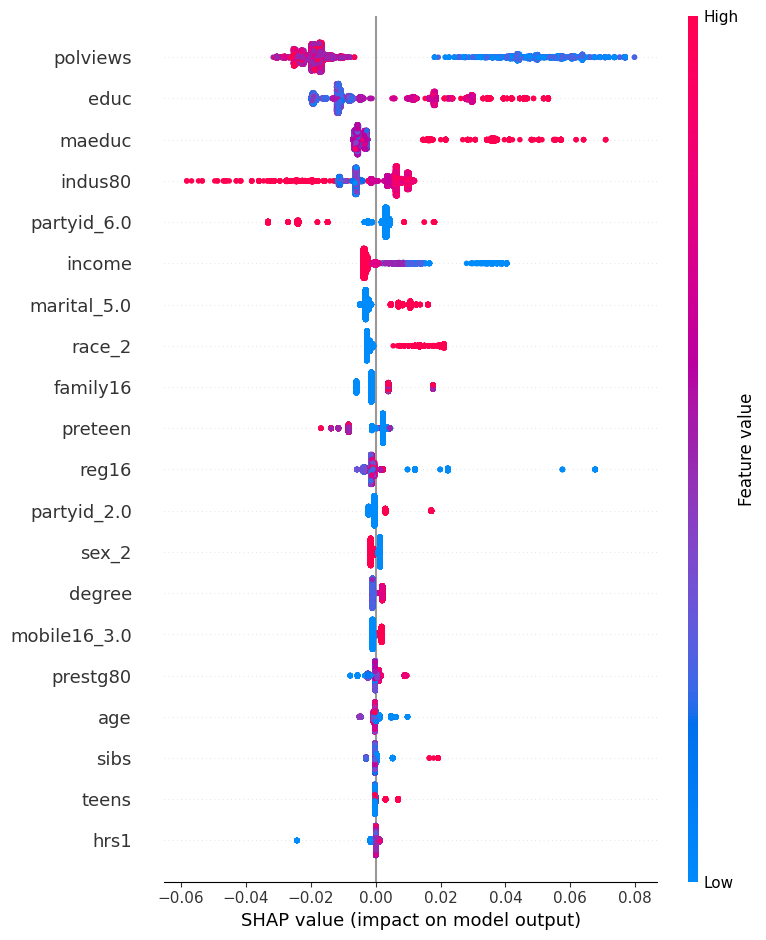

In [45]:
plt.figure()
shap.summary_plot(shap_values, Z.iloc[subsample], show=False)
plt.savefig(f'{data}-shap-values-dr.png', dpi=600)
plt.show()

# Causal Score Estimation and Definition

We want to be able to select among all these different meta learners. For this reason we will use scoring functions that can evaluate the performance of an arbitrary CATE function and is not tailored to any particular methodology. This way we can evaluate all methods using the same score on the validation set and select the best among the methods, or ensemble the methods using this scoring metric. We will describe one such meta scores, the `DR-score`.

## The Doubly Robust Score (DR-Score)

The doubly robust score calculates the doubly robust proxy variables $Y_i^{DR}(g,p)$, where $g,p$ are fitted on the training set (or on the validatino in a cross-fitting manner). Then for any candidate CATE model $\hat{\tau}$, the DR-score is the decrease in residual variance of $Y^{DR}(g,p)$ based on the candidate model as compared to a constant effect model.
\begin{align}
\text{DRscore}(\hat{\tau}) := E_n\left[\left(Y^{DR}(g,p) - \tau_{\text{constant}}(Z)\right)^2\right] - E_n\left[\left(Y^{DR}(g,p) - \hat{\tau}(Z)\right)^2\right]
\end{align}
We can also consider normalizing by the residual variance of the constant effect model
\begin{align}
\text{DRscore}(\hat{\tau}) := \frac{E_n\left[\left(Y^{DR}(g,p) - \tau_{\text{constant}}(Z)\right)^2\right] - E_n\left[\left(Y^{DR}(g,p) - \hat{\tau}(Z)\right)^2\right]}{E_n\left[\left(Y^{DR}(g,p) - \tau_{\text{constant}}(Z)\right)^2\right]}
\end{align}
for more interpretability, as this last quanity lies in $[-\infty, 1]$, and for any decent model it should be a positive number in $[0,1]$.

In [46]:
reg_zero_on_train = modely().fit(X[D == 0], y[D == 0])
reg_one_on_train = modely().fit(X[D == 1], y[D == 1])
prop_on_train = auto_clf().fit(X, D)

In [47]:
def calculate_dr_outcomes(reg_zero, reg_one, prop, Xval, Dval, yval):

    reg_zero_preds_t = reg_zero.predict(Xval)
    reg_one_preds_t = reg_one.predict(Xval)
    reg_preds_t = reg_zero_preds_t * (1 - Dval) + reg_one_preds_t * Dval
    prop_preds = prop.predict(Xval)

    dr = reg_one_preds_t - reg_zero_preds_t
    reisz = (Dval - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .01, np.inf)
    dr += (yval - reg_preds_t) * reisz

    return dr

In [48]:
dr_val = calculate_dr_outcomes(reg_zero_on_train, reg_one_on_train, prop_on_train,
                               Xval, Dval, yval)

overall_ate_val_dr = np.mean(dr_preds)


def drscore(cate_preds):
    drscore_t = np.mean((dr_val - cate_preds)**2)
    drscore_b = np.mean((dr_val - overall_ate_val_dr)**2)
    return drscore_b - drscore_t


def drscore_delta(cate_preds1, cate_preds2=overall_ate_val_dr):
    drscore_t = np.mean((dr_val - cate_preds1)**2)
    drscore_b = np.mean((dr_val - cate_preds2)**2)
    stderr = np.std((dr_val - cate_preds2)**2 - (dr_val - cate_preds1)**2) / np.sqrt(cate_preds1.shape[0])
    return drscore_b - drscore_t, stderr

## Compare models with confidence

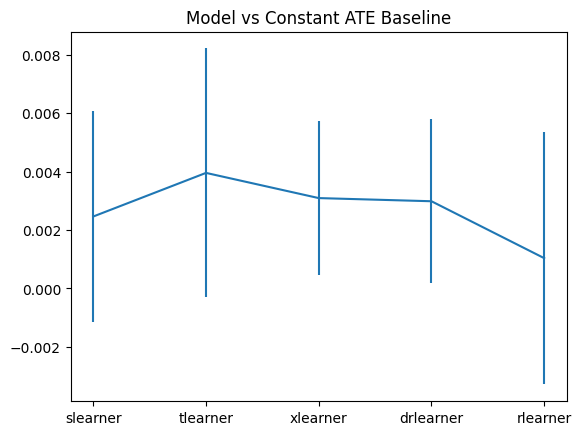

In [49]:
names = ['slearner', 'tlearner', 'xlearner', 'drlearner', 'rlearner']
models = [slearner, tlearner, xlearner, drlearner, rlearner]

points, ses = zip(*[drscore_delta(model.predict(Zval)) for model in models])
points = np.array(points)
ses = np.array(ses)

plt.errorbar(names, points, yerr=[1.96 * ses, 1.96 * ses])
plt.title('Model vs Constant ATE Baseline')
plt.savefig(f'{data}-model-comparison.png', dpi=600)
plt.show()

## Score CATE Models

In [50]:
scorer = drscore
score_name = 'DRscore'
names = ['slearner', 'tlearner', 'xlearner', 'drlearner', 'rlearner', 'drlearner_const']
models = [slearner, tlearner, xlearner, drlearner, rlearner, drlearner_const]

In [51]:
scores = [scorer(model.predict(Zval)) for model in models]
print([f'{name}: {score:.4f}' for name, score in zip(names, scores)])

['slearner: 0.0025', 'tlearner: 0.0040', 'xlearner: 0.0031', 'drlearner: 0.0030', 'rlearner: 0.0010', 'drlearner_const: -0.0000']


In [52]:
for name, model in zip(names, models):
    score = drscore_delta(model.predict(Zval))
    print(f'{name}: {score[0]:.4f} ({score[1]:.4f}) '
          f'[{score[0] - 1.96 * score[1]:.4f}, {score[0] + 1.96 * score[1]:.4f}]')

slearner: 0.0025 (0.0018) [-0.0011, 0.0061]
tlearner: 0.0040 (0.0022) [-0.0003, 0.0082]
xlearner: 0.0031 (0.0014) [0.0004, 0.0057]
drlearner: 0.0030 (0.0014) [0.0002, 0.0058]
rlearner: 0.0010 (0.0022) [-0.0033, 0.0054]
drlearner_const: -0.0000 (0.0000) [-0.0000, -0.0000]


# Plotting CATE

In [53]:
names

['slearner',
 'tlearner',
 'xlearner',
 'drlearner',
 'rlearner',
 'drlearner_const']

In [54]:
fnames = ['Single Learner', 'Two Learner', 'Cross Learner',
          'Doubly Robust Learner', 'Residual Learner', 'Doubly Robust ATE']

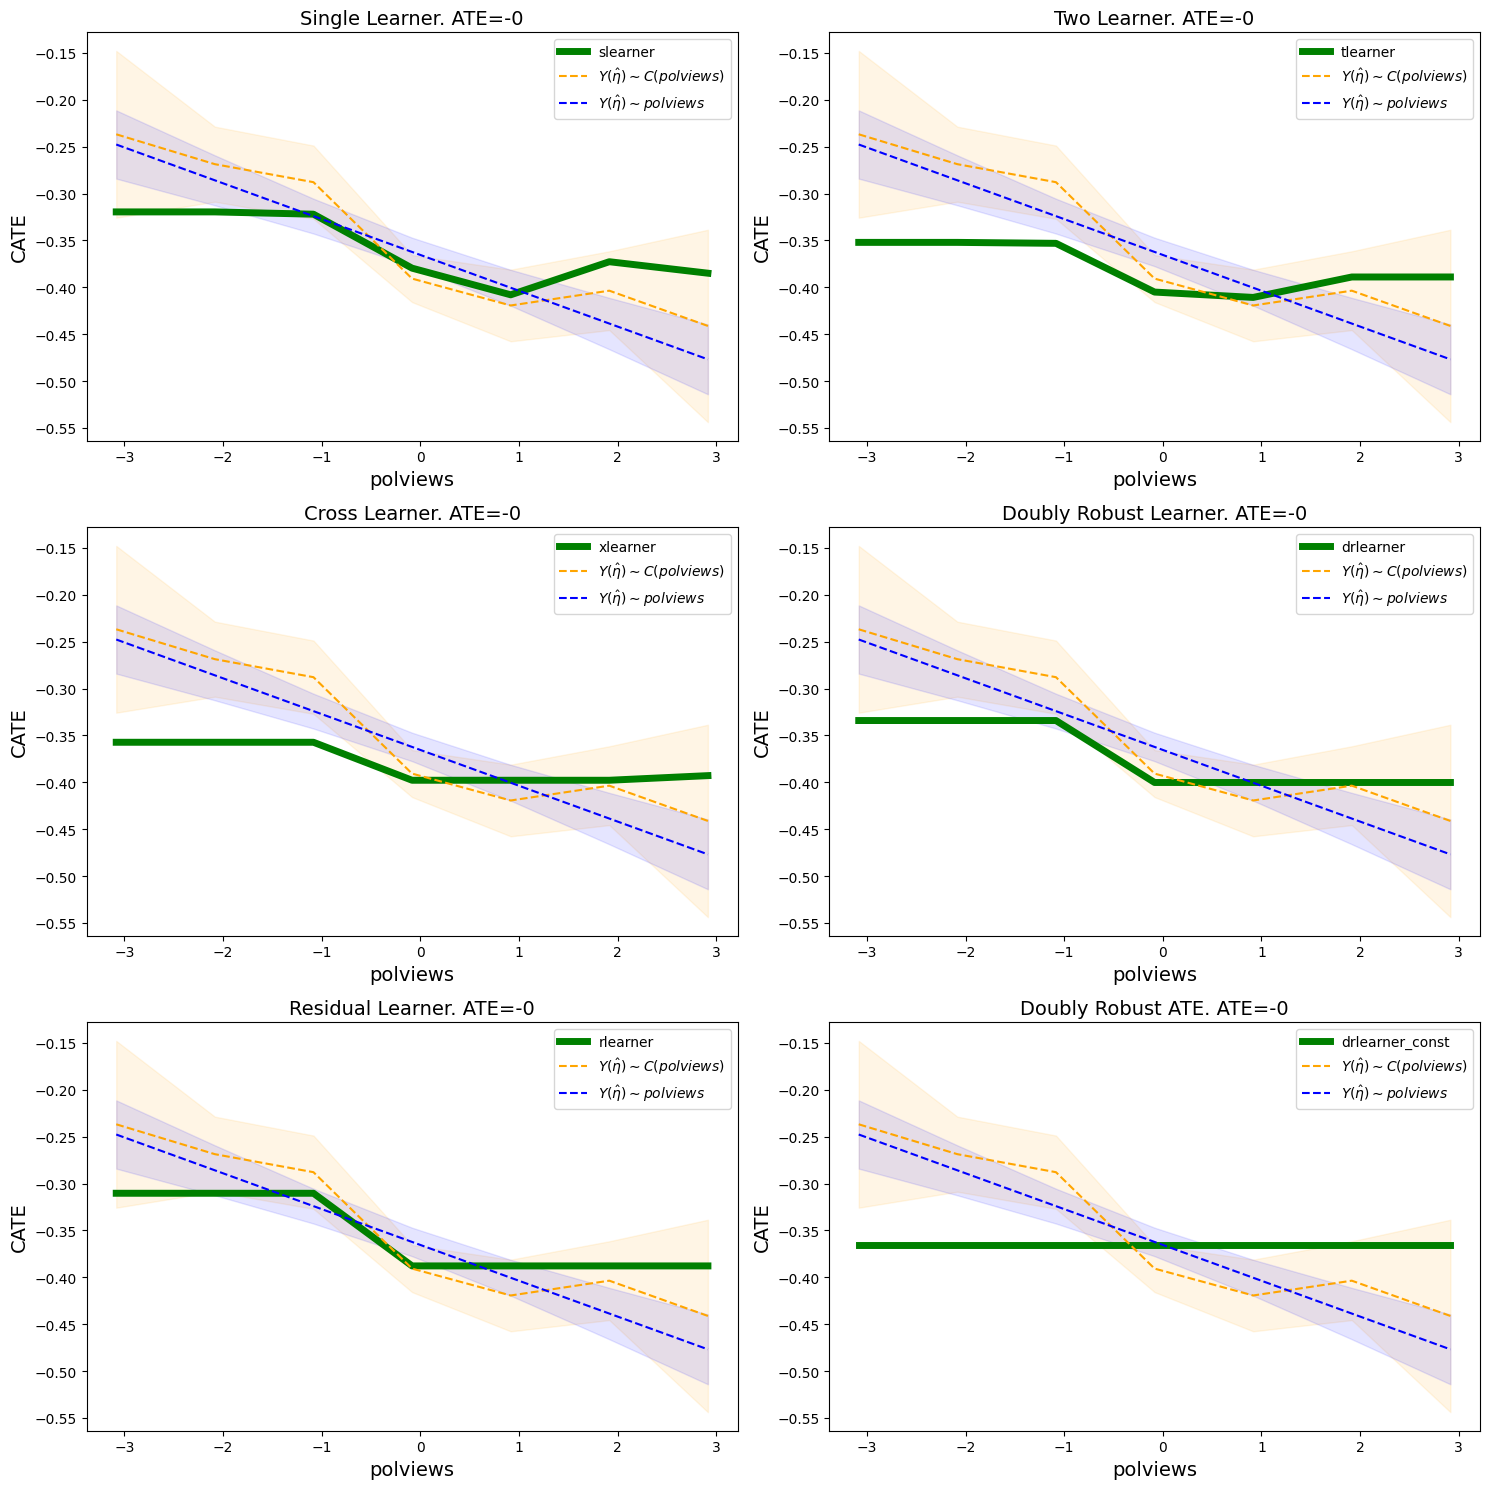

In [55]:
if plot:
    grid = np.unique(np.percentile(X[xfeat], np.arange(0, 102, 2)))
    Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                       columns=X.columns)
    Xpd[xfeat] = grid
    plt.figure(figsize=(15, 15))
    for it, (fname, name, model, score) in enumerate(zip(fnames, names, models, scores)):
        plt.subplot(3, len(models) // 3, it + 1)
        preds = model.predict(Xpd[hetero_feats])
        plt.plot(Xpd[xfeat], preds, linewidth=5, color='green', label=name)
        plt.plot(Xpd[xfeat], pred_df['mean'], '--',
                 color='orange', label='$Y(\\hat{\\eta})\\sim ' + f'{blp_formula_short}$')
        plt.fill_between(Xpd[xfeat], pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], color='orange', alpha=.1)
        plt.plot(Xpd[xfeat], pred_df2['mean'], '--',
                 color='blue', label='$Y(\\hat{\\eta})\\sim ' + f'{blp_formula2_short}$')
        plt.fill_between(Xpd[xfeat], pred_df2['mean_ci_lower'], pred_df2['mean_ci_upper'], color='blue', alpha=.1)
        if semi_synth:
            plt.plot(Xpd[xfeat], true_cate(Xpd), label='True')
            plt.title(f'{score_name}={score:.4f}, True RMSE={rmse(true_cate(X), model.predict(Z)):.5f}')
        else:
            plt.title(f'{fname}. ATE={np.mean(model.predict(Zval)):.0f}', fontsize=14)
        plt.legend()
        plt.xlabel(xfeat, fontsize=14)
        plt.ylabel('CATE', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{data}-metalearners.png', dpi=600)
    plt.show()

# Causal Model Selection and Ensembling

We can also use these scores to create an ensemble CATE model of the different methods based on the score performance. We want to create a new CATE model $\tau_E$ that is a weighted linear combination of all the cate models, i.e.
\begin{align}
\tau_E(Z) = \bar{\tau} + \sum_{m=1}^M w_m \tau_m(Z)
\end{align}
One way to achieve that is to choose the model with the best score. However, the discontinuity in this selection process can be statistically suboptimal. One way to achieve this in a smoother manner is to perform Stacking to construct the ensemble weights.

In [56]:
from sklearn.base import BaseEstimator


class Ensemble(BaseEstimator):

    def __init__(self, names, models, weights, intercept=0):
        self.names = names
        self.models = models
        self.weights = weights
        self.intercept = intercept

    def predict(self, X):
        wcate = np.sum(self.weights.reshape((-1, 1)) * np.array([m.predict(X) for m in self.models]), axis=0)
        return self.intercept + wcate

We perform Stacking by fitting a (potentially $\ell_1$-penalized) linear model to minimize the corresponding loss. For the case of the DR score this boils down to a penalized linear regression, predicting $Y^{DR}(g,p)$ on the validation set, using $\tau_1(Z),\ldots, \tau_M(Z)$ as technical regressors:
\begin{align}
\min_{w} E_n\left[ \left(Y^{DR}(g,p) - \bar{\tau} - \sum_{m=1}^M w_m \tilde{\tau}_m(Z)\right)^2 \right] + \lambda \text{Penalty}(w)
\end{align}
where $\bar{\tau}$ is the ATE estimate based on the doubly robust method on the training data and $\tilde{\tau}_m(Z)$ are the de-meaned CATE predictions from each model, i.e. $\tilde{\tau}_m(Z) = \tau_m(Z) - E_n[\tau_m(Z)]$ where the empirical expectation is over the training data.

This way we are constructing an ensemble of the CATE on top of the best constant prediction on the training data and penalizing only the offset from this ATE. We avoid adding a coefficient around $\bar{\tau}$ to avoid introducing noise to the ATE estimate, due to the smaller sample in the validation set.

In [57]:
from sklearn.linear_model import RidgeCV, LinearRegression

F = np.array([m.predict(Zval) for m in models]).T
meansF = np.mean(F, axis=0)
F = F - meansF

stack_models = {}
stack_variants = [('OLS', LinearRegression(fit_intercept=False)),
                  ('OLS (positive)', LinearRegression(fit_intercept=False, positive=True)),
                  ('LassoCV', LassoCV(fit_intercept=False)),
                  ('LassoCV (positive)', LassoCV(fit_intercept=False, positive=True)),
                  ('RidgeCV', RidgeCV(fit_intercept=False))]

for stackname, stacker in stack_variants:
    stacker.fit(F, dr_val - np.mean(dr_preds))
    intercept = np.mean(dr_preds) - meansF @ stacker.coef_
    stack_models[stackname] = Ensemble(names, models, stacker.coef_, intercept)

Q-aggregation optimizes a penalized objective of the form:
\begin{align}
\min_{w\in \Delta(M)} (1 - \nu) E_n\left[ \left(Y^{DR}(g,p) - \bar{\tau} - \sum_{m=1}^M w_m \tilde{\tau}_m(Z)\right)^2 \right] + \nu \sum_{m=1}^M w_m E_n\left[ \left(Y^{DR}(g,p) - \bar{\tau} - \tilde{\tau}_m(Z)\right)^2 \right]
\end{align}
where $\Delta(M)$ is the simplex in $M$ dimensions, i.e.
\begin{align}
\Delta(M) := \{w\in R^M: w_i\geq 0, \sum_{m=1}^M w_m=1\}.
\end{align}

In other words, it chooses a convex combination of models, but penalizes models which do not perform well individually. Note that when $\nu=0$, then this boils down to what is known as "convex regression", i.e. OLS regression subject to a simplex constraint on the coefficients. When $\nu=1$, then the above boils down to choosing the single best performing model. Hence, Q-aggregation interpolates between the best convex combination of models and the single best performing model. It enjoys favorable theoretical guarantees as compared to either of the two extremes.

In [58]:
def instance(nu, U, y):
    n = y.shape[0]
    ploss = np.mean((y.reshape(1, -1) - U)**2, axis=1)

    def loss(x):
        return np.mean((y - U.T @ x)**2)

    def qfunction(x):
        return (1 - nu) * loss(x) + nu * x @ ploss

    def grad_q(x):
        return - 2 * (1 - nu) * U @ (y - U.T @ x) / n + nu * ploss

    return loss, qfunction, grad_q, ploss


def opt(K, qfunction, grad_q):
    res = scipy.optimize.minimize(qfunction, np.ones(K) / K, jac=grad_q, bounds=[(0, 1)] * K,
                                  constraints=scipy.optimize.LinearConstraint(np.ones((1, K)), lb=1, ub=1),
                                  tol=1e-18)
    return res.x


def qagg(F, y, nu=.5):
    scale = max(np.max(np.abs(F)), np.max(np.abs(y)))
    loss, qfunction, grad_q, ploss = instance(nu, F.T / scale, y / scale)
    return opt(F.shape[1], qfunction, grad_q)

In [59]:
F = np.array([m.predict(Zval) for m in models]).T
weights = qagg(F, dr_val)
stack_models['Q-aggregation'] = Ensemble(names, models, weights, 0.0)

In [60]:
F = np.array([m.predict(Zval) for m in models]).T
weights = qagg(F, dr_val, nu=0.0)
stack_models['OLS (simplex)'] = Ensemble(names, models, weights, 0.0)

In [61]:
F = np.array([m.predict(Zval) for m in models]).T
weights = qagg(F, dr_val, nu=1.0)
stack_models['Best'] = Ensemble(names, models, weights, 0.0)

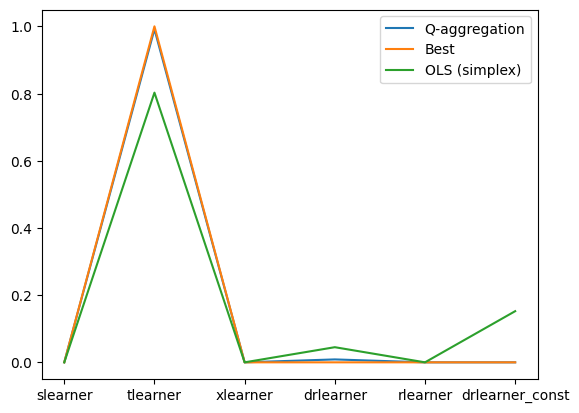

In [62]:
plt.plot(names, stack_models['Q-aggregation'].weights, label='Q-aggregation')
plt.plot(names, stack_models['Best'].weights, label='Best')
plt.plot(names, stack_models['OLS (simplex)'].weights, label='OLS (simplex)')
plt.legend()
plt.show()

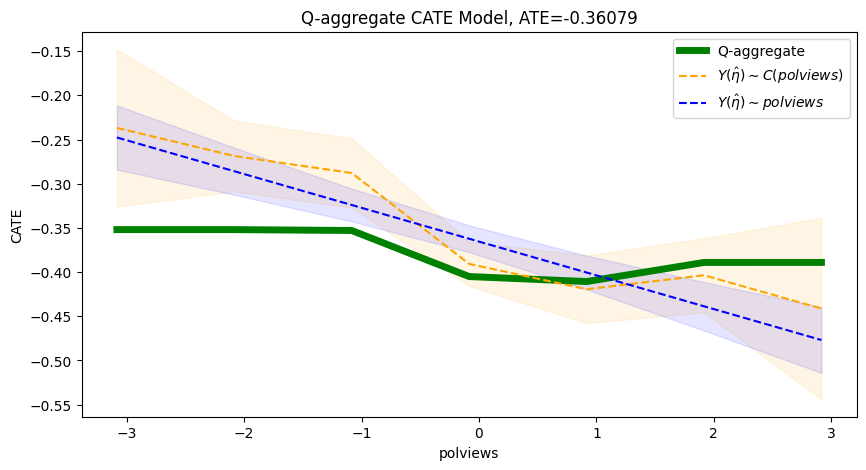

In [63]:
if plot:
    stack_ensemble = stack_models['Q-aggregation']
    grid = np.unique(np.percentile(X[xfeat], np.arange(0, 102, 2)))
    Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                       columns=X.columns)
    Xpd[xfeat] = grid
    plt.figure(figsize=(10, 5))
    plt.plot(Xpd[xfeat], stack_ensemble.predict(Xpd[hetero_feats]),
             linewidth=5, color='green',
             label='Q-aggregate')
    plt.plot(Xpd[xfeat], pred_df['mean'], '--', color='orange',
             label='$Y(\\hat{\\eta})\\sim ' + f'{blp_formula_short}$')
    plt.fill_between(Xpd[xfeat], pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], color='orange', alpha=.1)
    plt.plot(Xpd[xfeat], pred_df2['mean'], '--', color='blue',
             label='$Y(\\hat{\\eta})\\sim ' + f'{blp_formula2_short}$')
    plt.fill_between(Xpd[xfeat], pred_df2['mean_ci_lower'], pred_df2['mean_ci_upper'], color='blue', alpha=.1)
    if semi_synth:
        plt.plot(Xpd[xfeat], true_cate(Xpd), '--', label='True')
        plt.title(f'{score_name}={scorer(stack_ensemble.predict(Zval)):.5f}, '
                  f'True RMSE={rmse(true_cate(X), stack_ensemble.predict(Z)):.5f}')
    else:
        plt.title('Q-aggregate CATE Model, '
                  f'ATE={np.mean(stack_ensemble.predict(Zval)):.5f}')
    plt.xlabel(xfeat)
    plt.ylabel('CATE')
    plt.legend()
    plt.savefig(f'{data}-qagg.png', dpi=600)
    plt.show()

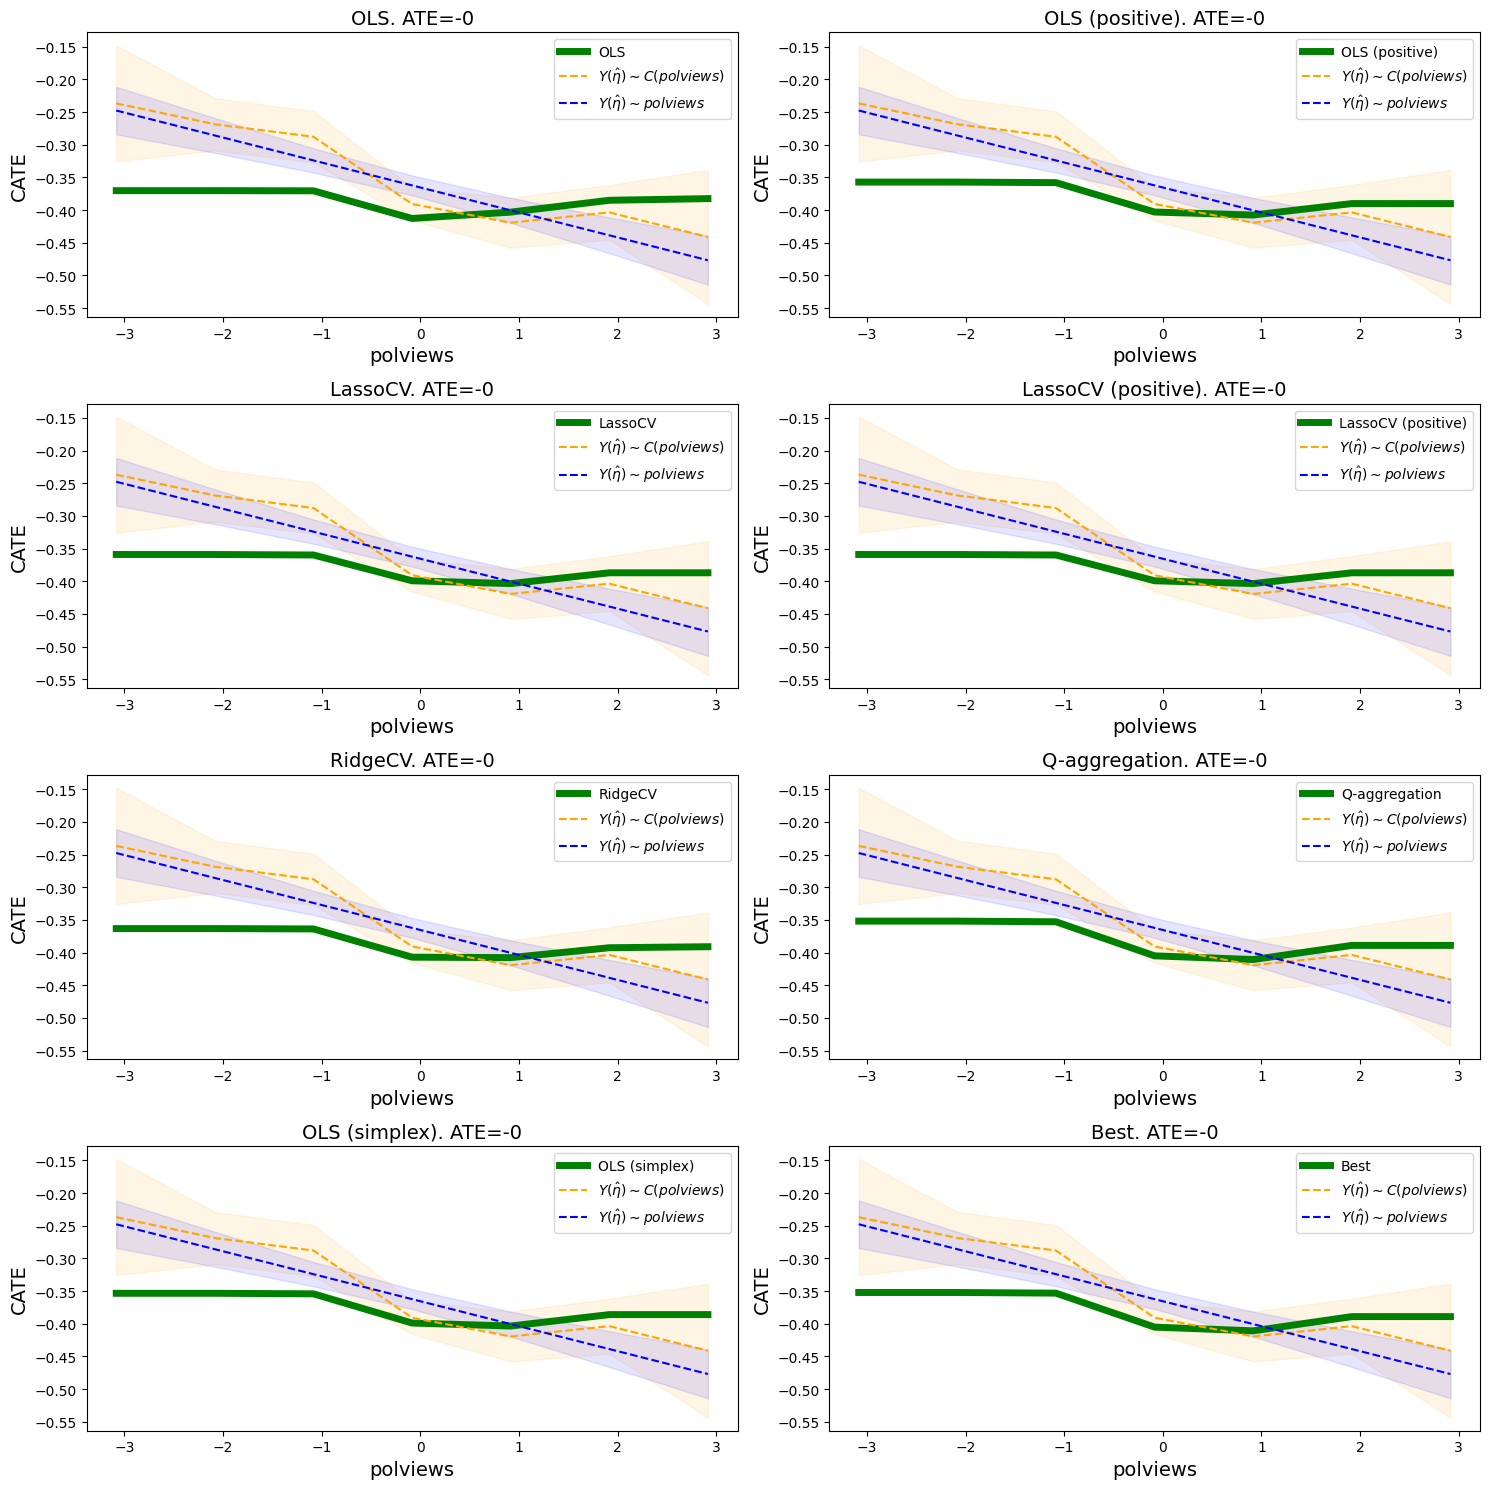

In [64]:
if plot:
    grid = np.unique(np.percentile(X[xfeat], np.arange(0, 102, 2)))
    Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                       columns=X.columns)
    Xpd[xfeat] = grid
    plt.figure(figsize=(15, 15))
    for it, (name, model) in enumerate(stack_models.items()):
        plt.subplot(4, len(stack_models) // 4, it + 1)
        preds = model.predict(Xpd[hetero_feats])
        plt.plot(Xpd[xfeat], preds, linewidth=5, color='green', label=name)
        plt.plot(Xpd[xfeat], pred_df['mean'], '--', color='orange',
                 label='$Y(\\hat{\\eta})\\sim ' + f'{blp_formula_short}$')
        plt.fill_between(Xpd[xfeat], pred_df['mean_ci_lower'], pred_df['mean_ci_upper'],
                         color='orange', alpha=.1)
        plt.plot(Xpd[xfeat], pred_df2['mean'], '--', color='blue',
                 label='$Y(\\hat{\\eta})\\sim ' + f'{blp_formula2_short}$')
        plt.fill_between(Xpd[xfeat], pred_df2['mean_ci_lower'], pred_df2['mean_ci_upper'],
                         color='blue', alpha=.1)
        if semi_synth:
            plt.plot(Xpd[xfeat], true_cate(Xpd), label='True')
            plt.title(f'True RMSE={rmse(true_cate(X), model.predict(Z)):.5f}')
        else:
            plt.title(f'{name}. ATE={np.mean(model.predict(Zval)):.0f}', fontsize=14)
        plt.legend()
        plt.xlabel(xfeat, fontsize=14)
        plt.ylabel('CATE', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{data}-stacked_ensembles.png', dpi=600)
    plt.show()

We use one of these ensembles as our final best model

In [65]:
overall_best = stack_models['Q-aggregation']

# Interpret with SHAP Values

In [66]:
import shap

subsample = np.random.choice(Z.shape[0], min(1000, Z.shape[0]), replace=False)
explainer = shap.Explainer(overall_best.predict, masker=Z.iloc[subsample])
subsample = np.random.choice(Z.shape[0], min(100, Z.shape[0]), replace=False)
shap_values = explainer(Z.iloc[subsample])

PermutationExplainer explainer: 101it [00:44,  1.85it/s]


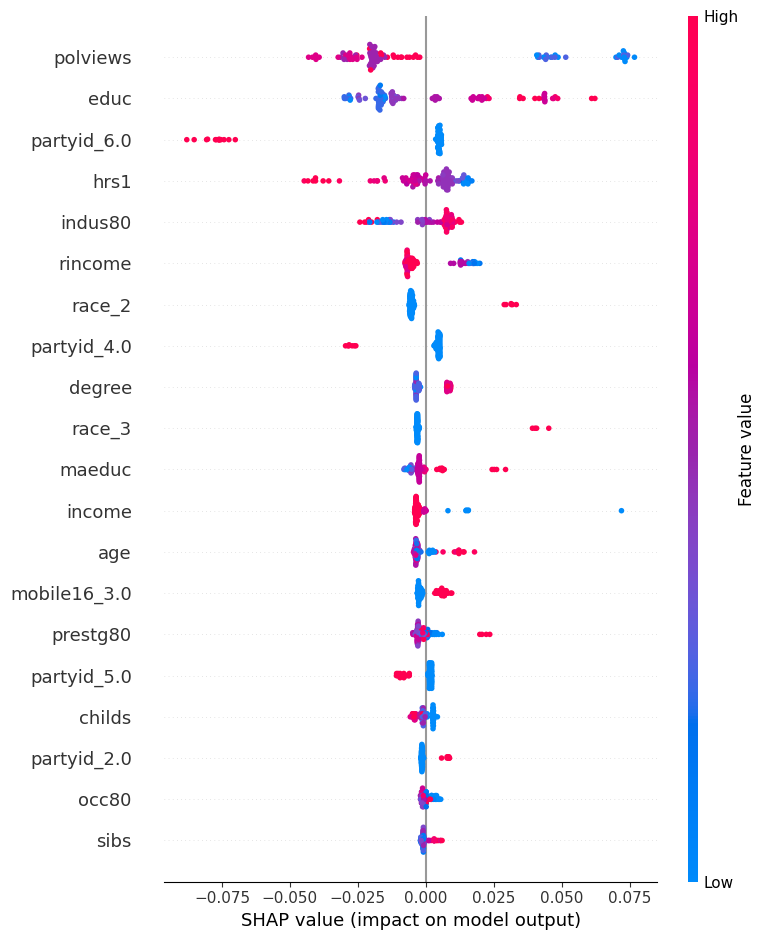

In [67]:
plt.figure()
shap.summary_plot(shap_values, Z.iloc[subsample], show=False)
plt.savefig(f'{data}-shap-values.png', dpi=600)
plt.show()

# Interpret with Distillation Trees

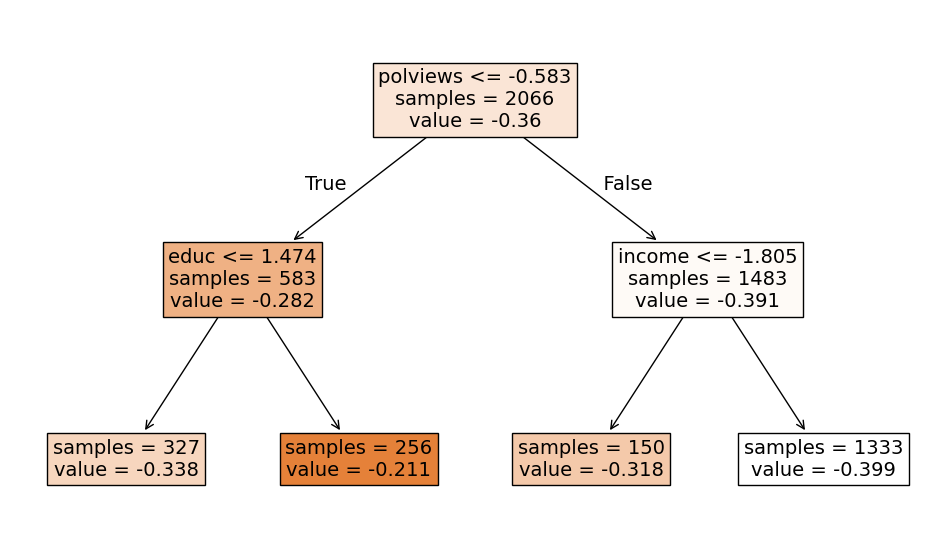

In [68]:
plt.figure(figsize=(12, 7))
tree = DecisionTreeRegressor(max_depth=2, min_samples_leaf=100,
                             min_impurity_decrease=.00001, random_state=random_seed)
tree.fit(Ztest, overall_best.predict(Ztest))
plot_tree(tree, filled=True, feature_names=list(Ztest.columns), fontsize=14, impurity=False)
plt.savefig(f'{data}-distill-tree-cate.png', dpi=600)
plt.show()

# Validation Tests on Test Data

Now that we have a selected a winning CATE model (or ensemble), we can run a set of hypothesis tests and other diagnostic metrics on the test set, to see if the model really picked up some dimensions of effect heterogeneity and satisfies some self-conistency checks.

### Hypothesis Test Based on Doubly Robust Best-Linear Predictor of CATE using model of CATE

If we calculate the doubly robust pseudo outcomes $Y^{DR}(g,p)$ on the test set, using cross-fitting to estimate the models $g,p$, then we know that if the model of the CATE $\hat{\tau}$ is good, then the best linear predictor of the true CATE using $(1, \hat{\tau}(Z))$ as features should have a statistically significant coefficient on the feature associated with the CATE model. In fact, in an ideal world it should have a coefficient of $1$. Thus we can run such a significance test to measure whether the CATE model $\tau_m$ has picked up anything signal that is correlated with the true CATE. Note that if $\theta(X)$ is the true CATE $E[Y(1)-Y(0)\mid X]$, then the coefficient associated with $\hat{\tau}$ in this regression can be interpreted as identifying the quantity:
\begin{align}
\beta_1 := \frac{\text{Cov}(\theta(X), \hat{\tau}(Z))}{\text{Var}(\hat{\tau}(Z))} = \frac{\text{Cov}(Y(1)-Y(0), \hat{\tau}(Z))}{\text{Var}(\hat{\tau}(Z))}
\end{align}

In [69]:
dr_test = calculate_dr_outcomes(reg_zero_on_train, reg_one_on_train, prop_on_train,
                                Xtest, Dtest, ytest)
cate_test = overall_best.predict(Ztest)

In [70]:
res = OLS(dr_test, np.stack((np.ones(len(dr_test)), cate_test - np.mean(cate_test)), axis=-1))
res = res.fit(cov_type='HC1').summary()

In [71]:
res

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     50.07
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           2.02e-12
Time:                        00:10:47   Log-Likelihood:                -2492.9
No. Observations:                2066   AIC:                             4990.
Df Residuals:                    2064   BIC:                             5001.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3642      0.018    -20.461      0.000      -0.399      -0.329
x1             1.4650      0.207      7.076      0.000       1.059       1.871
==============================================================================
Omnibus:                      124.701   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.418
Skew:                           0.469   Prob(JB):                     3.49e-23
Kurtosis:                       2.432   Cond. No.                         12.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### Validation Based on Calibration

We can measure whether each group defined by the quartile levels of CATE predictions is consistent with the out-of-sample Group ATE (GATE) for the corresponding group based on the doubly robust GATE estimate. (standard errors here ignore cluster/group correlations)

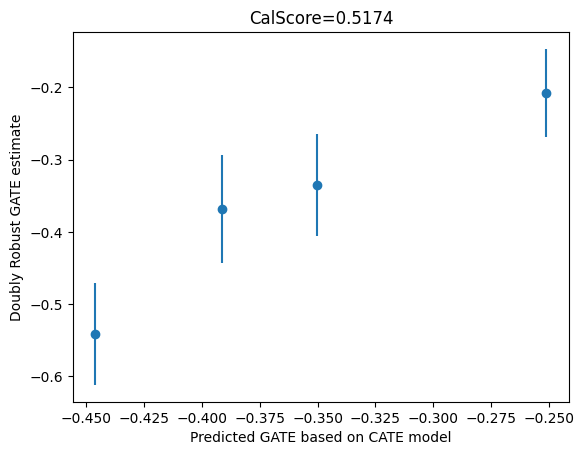

In [72]:
cate_val = overall_best.predict(Zval)
qs = np.percentile(cate_val, np.arange(0, 101, 25))

gate, gate_std, group_prob = np.zeros(len(qs) - 1), np.zeros(len(qs) - 1), np.zeros(len(qs) - 1)
predicted_gate = np.zeros(len(qs) - 1)
for it in range(len(qs) - 1):
    # samples in the [q[it], q[it+1]) quantile group of predicted CATEs
    inds = (qs[it] <= cate_test) & (cate_test <= qs[it + 1])
    gate[it] = np.mean(dr_test[inds])  # DR estimate of group average treatment effect (GATE)
    gate_std[it] = np.std(dr_test[inds]) / np.sqrt(np.sum(inds))  # standard error of GATE
    group_prob[it] = np.mean(inds)  # probability mass of group
    predicted_gate[it] = np.mean(cate_test[inds])  # GATE as calculated from CATE model

# weighted average calibration error of cate model
cal = np.sum(group_prob * np.abs(gate - predicted_gate))
# weighted average calibration error of a constant cate model
calbase = np.sum(group_prob * np.abs(gate - np.mean(dr_test)))
# calibration score
calscore = 1 - cal / calbase
plt.title(f'CalScore={calscore:.4f}')
plt.errorbar(predicted_gate, gate, yerr=1.96 * gate_std, fmt='o')
plt.xlabel('Predicted GATE based on CATE model')
plt.ylabel('Doubly Robust GATE estimate')
plt.savefig(f'{data}-calibration-score.png', dpi=600)
plt.show()

We can also try to interpret what are the differences of characteristics between the top and bottom CATE groups; if we find that they have statistically significantly different GATEs. We can do that by either reporting the mean values of the covariates in the two groups or building some interpretable classification model that distinguishes between the two groups.

In [73]:
group1 = (qs[0] <= cate_test) & (cate_test < qs[3])
group2 = (qs[-2] <= cate_test) & (cate_test < qs[-1])
Ztest1 = Ztest[group1]
Ztest2 = Ztest[group2]

In [74]:
diff_stderr = np.std(Ztest1, axis=0) / np.sqrt(Ztest1.shape[0]) + np.std(Ztest2, axis=0) / np.sqrt(Ztest2.shape[0])
df = pd.DataFrame({'group1 means': np.mean(Ztest1, axis=0),
                   'group1 s.e.': np.std(Ztest1, axis=0) / np.sqrt(Ztest1.shape[0]),
                   'group2 means': np.mean(Ztest2, axis=0),
                   'group2 s.e.': np.std(Ztest2, axis=0) / np.sqrt(Ztest2.shape[0]),
                   'group1 means - group2 means': np.mean(Ztest1, axis=0) - np.mean(Ztest2, axis=0),
                   'diff s.e.': diff_stderr})
df

,group1 means,group1 s.e.,group2 means,group2 s.e.,group1 means - group2 means,diff s.e.
hrs1,1.685448,0.345224,-3.987597,0.632577,5.673044,0.977800
income,0.291976,0.023389,-0.858375,0.113145,1.150351,0.136535
rincome,0.275019,0.062033,-0.902284,0.152310,1.177303,0.214344
age,0.728178,0.298948,-1.647453,0.561552,2.375631,0.860501
polviews,0.363942,0.030452,-1.025416,0.057777,1.389358,0.088229
educ,-0.371236,0.060677,1.441588,0.130396,-1.812824,0.191073
earnrs,0.037263,0.020514,-0.191986,0.033040,0.229249,0.053554
sibs,0.076082,0.074874,0.033526,0.129383,0.042557,0.204257
childs,0.043040,0.037050,-0.364584,0.064101,0.407624,0.101150
occ80,21.656056,6.426860,-75.027003,9.101449,96.683059,15.528309


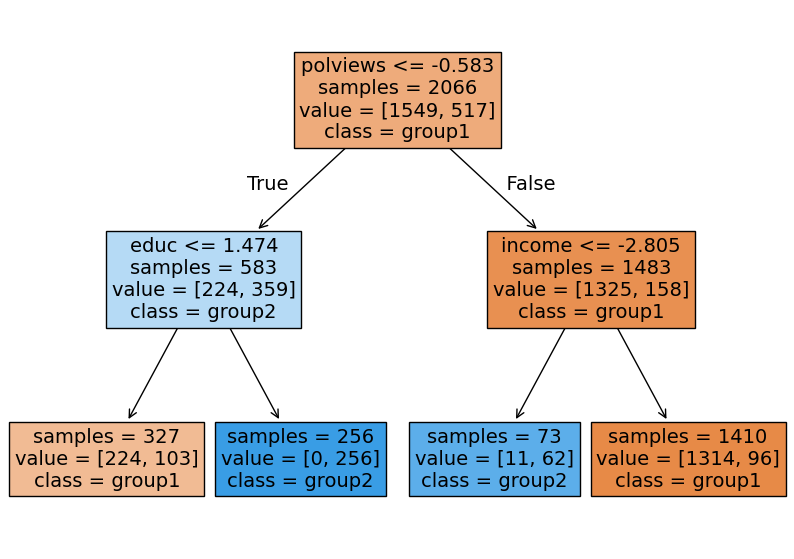

In [75]:
plt.figure(figsize=(10, 7))
tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=50, min_impurity_decrease=.01)
tree.fit(pd.concat((Ztest1, Ztest2)),
         np.concatenate((np.zeros(len(Ztest1)), np.ones(len(Ztest2)))))
plot_tree(tree, filled=True, feature_names=list(Ztest1.columns),
          class_names=['group1', 'group2'], fontsize=14, impurity=False)
plt.savefig(f'{data}-distill-groups-tree-cate.png', dpi=600)
plt.show()

### Validation Based on Uplift Curves

These curves are related to "prioritization" or "stratification" implications of the CATE model. What if we target to treat a $q$-percentage of the population. Then if we trust and follow the CATE model, then we should be offering the treatment to the parts of the population that the CATE model predicts have a CATE larger than the $1-q$-th percentile of the CATE distribution as produced by the CATE.

In this case, we might care about the group average treatment effect of the group of people that are treated under such a prioritization rule and how that compares with the overall average treatment effect. Ideally, the group average treatment effect should be larger than the overall average treatment effect if the prioritization rule is correct.

Thus if we have a rough estimate $\hat{\mu}(q)$ of the $1-q$-quantile $\mu(q)$ of the CATE predictions distribution we can calculate:
\begin{align}
\tau(q) =~& E[Y(1) - Y(0) \mid \hat{\tau}(Z) \geq \hat{\mu}(q)] - E[Y(1) - Y(0)]\\
=~& E\left[(Y(1) - Y(0)) \frac{1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}}{\Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))}\right] - E[Y(1) - Y(0)]
~=~ \text{Cov}\left(Y(1) - Y(0), \frac{1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}}{\Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))}\right)
\end{align}
We can get such good quantile estimates out-of-sample, by looking at the $1-q$-the empirical quantile of the cate predictions on a sample other than the one that we are using to calculate $\tau(q)$. For instance, we can use the training/validation samples but not the test samples. This gives us a set of thresholds $\hat{\mu}(q_1), \ldots, \hat{\mu}(q_m)$ that are good approximations of the quantile of the predicted CATE distribution. If we target to treat every person with CATE greater than $\hat{\mu}(q_t)$ we should expect roughly $q_t$ fraction of the population to be treated.

This quantity is identified by replacing the individual effects with the doubly robust pseudo-outcomes:
\begin{align}
\tau(q) =~& E\left[Y^{DR}(g,p) \mid \hat{\tau}(Z) \geq \hat{\mu}(q)\right] - E\left[Y^{DR}(g,p)\right]
~=~ \text{Cov}\left(Y^{DR}(g,p), \frac{1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}}{\Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))}\right)
\end{align}

We can then plot the curve $\tau(q)$, understand the Area Under the Curve:
\begin{align}
AUTOC := \int_0^1 \tau(q) dq
\end{align}
and run tests whether that area is positive or that there is any positive point in the curve. These are tests that indicate that the CATE model detected heterogeneity with statistical significance. Moreover, the larger the Area Under the Curve, the better the CATE model is at treatment prioritization. (standard errors here ignore cluster/group correlations)

We also need to be able to handle tie-breaking in case where the $\hat{\mu}(q)$ curve contains regions where the quantile is flat. We will use the following type of formula for that case
\begin{align}
\tau(q) =~& E[A \mid T<C, (T=C, U<q)] - E[A]\\
=~& E\left[A \frac{1\{T<C, (T=C, U<q)\}}{Pr}\right] - E[A]\\
=~& E\left[A \frac{1\{T<C\} + 1\{T=C\} q}{Pr(T<C) + Pr(T=C) q}\right] - E[A]\\
=~& Cov\left(A, \frac{1\{T<C\} + 1\{T=C\} q}{Pr(T<C) + Pr(T=C) q}\right)
\end{align}

In [76]:
# Based on out-of-sample CATE thresholds
ugrid = np.linspace(5, 95, 50)
qs = np.percentile(overall_best.predict(Zval), ugrid)

toc, toc_std, group_prob = np.zeros(len(qs)), np.zeros(len(qs)), np.zeros(len(qs))
true_toc = np.zeros(len(qs))
toc_psi = np.zeros((len(qs), dr_test.shape[0]))  # influence function representation of the TOC at each quantile
n = len(dr_test)
ate = np.mean(dr_test)
uqs, ind, cnt = np.unique(qs, return_counts=True, return_index=True)
for it, u in enumerate(ugrid):
    # calculating tie breaking fraction
    intv = np.searchsorted(ugrid[ind], u, side='right') - 1
    q, i, c = uqs[intv], ind[intv], cnt[intv]
    nextu = (ugrid[i + c + 1] if i + c + 1 < len(ugrid) else 100)
    remnant = nextu - u
    frac = remnant / (nextu - ugrid[i])

    inds = (q < cate_test) + (cate_test == q) * frac  # group with larger CATE prediction than the q-th quantile
    group_prob = np.mean(inds)
    toc[it] = np.mean(dr_test * inds / group_prob) - ate  # tau(q) := E[Y(1) - Y(0) | tau(X) >= q[it]] - E[Y(1) - Y(0)]
    # influence function for the tau(q); it is a standard influence function of a "covariance"
    toc_psi[it, :] = (dr_test - ate) * (inds / group_prob - 1) - toc[it]
    toc_std[it] = np.sqrt(np.mean(toc_psi[it]**2) / n)  # standard error of tau(q)
    if semi_synth:
        true_toc[it] = np.mean((true_cate(Xtest) - np.mean(true_cate(Xtest))) * (inds / group_prob - 1))

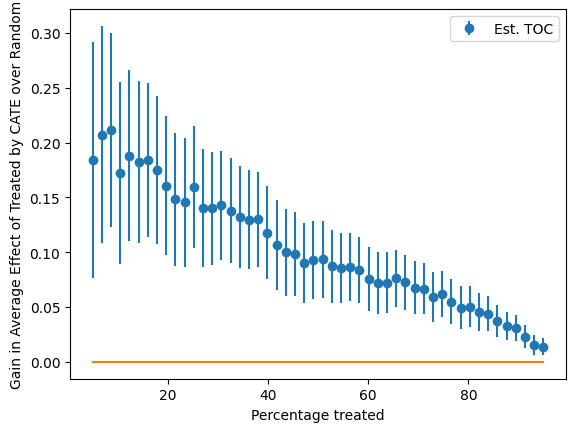

In [77]:
plt.errorbar(100 - ugrid, toc, yerr=1.96 * toc_std, fmt='o', label='Est. TOC')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True TOC')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.legend()
plt.savefig(f'{data}-toc.png', dpi=600)
plt.show()

In [78]:
V = toc_psi @ toc_psi.T / toc_psi.shape[1]
sigmas = np.sqrt(np.diag(V))
V /= sigmas.reshape(-1, 1)
V /= sigmas.reshape(1, -1)

In [79]:
epsilon = np.random.multivariate_normal(np.zeros(V.shape[0]), V, size=(100000))
uniform_critical_value = np.percentile(np.max(np.abs(epsilon), axis=1), 95)
uniform_critical_value

2.951785616572031

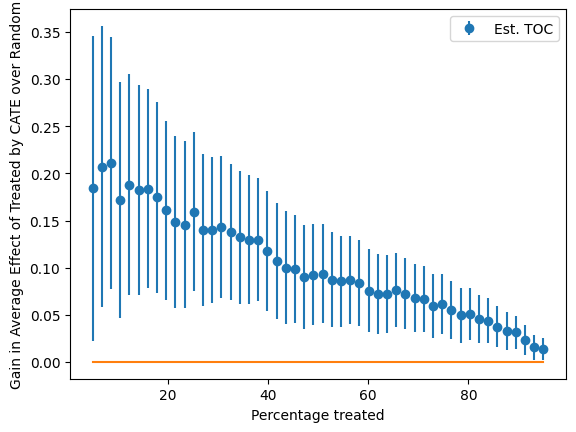

In [80]:
plt.errorbar(100 - ugrid, toc, yerr=uniform_critical_value * toc_std, fmt='o', label='Est. TOC')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True TOC')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.legend()
plt.savefig(f'{data}-toc-uniform-band.png', dpi=600)
plt.show()

Note that if there is any point that is above the zero line, with confidence, in this curve, then the CATE model $\hat{\tau}$ has identified heterogeneity in the effect in a statistically significant manner. To do this we need a one-sided confidence interval, as we only care that the quantities are larger than some value with high confidence. We can then calculate the critical value for a uniform one-sided confidence interval across all the points.

In [81]:
uniform_one_side_critical_value = np.percentile(np.max(np.abs(epsilon), axis=1), 90)
print(uniform_one_side_critical_value)

2.694174259130196


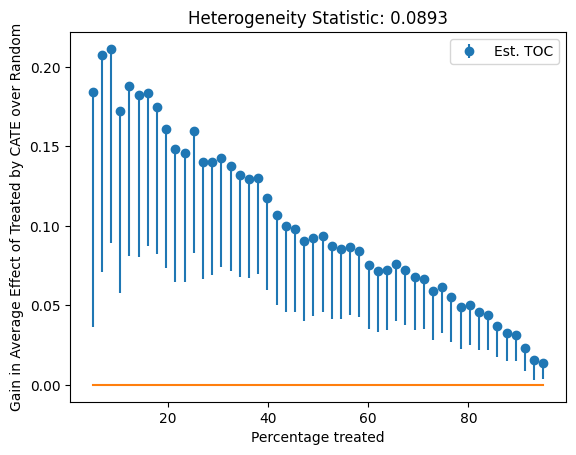

In [82]:
plt.errorbar(100 - ugrid, toc,
             yerr=[uniform_one_side_critical_value * toc_std, np.zeros(len(toc))], fmt='o', label='Est. TOC')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True TOC')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.title(f'Heterogeneity Statistic: {np.max(toc - uniform_one_side_critical_value*toc_std):.4f}')
plt.legend()
plt.savefig(f'{data}-toc-one-sided-band.png', dpi=600)
plt.show()

We can also calcualte the area under the curve and the confidence interval for that area. If the confidence interval does not contain zero, then we have again detected heterogeneity.

In [83]:
autoc_psi = np.sum(toc_psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
autoc = np.sum(toc[:-1] * np.diff(ugrid) / 100)
autoc_stderr = np.sqrt(np.mean(autoc_psi**2) / n)
print(f'AUTOC: {autoc:.4f}, s.e.: {autoc_stderr:.4f}, '
      f'One-Sided 95% CI=[{autoc - scipy.stats.norm.ppf(.95) * autoc_stderr:.4f}, Infty]')

AUTOC: 0.0909, s.e.: 0.0132, One-Sided 95% CI=[0.0692, Infty]


### Qini Curve

Similar to the $\tau(q)$ curve, we can also consider a small variant of that curve that also incorporates the probability of treatment. So instead of looking just at the group average effect of the group of people that are prioritized by the CATE model and subtract the overall effect, we can look at the "total value" exctracted by the treated group and contrast it with the total value that would be extracted by an equally large group treated uniformly at random. This corresponds to:
\begin{align}
\tau_{\text{QINI}}(q) :=~& \tau(q)\, \Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))\\
=~& \left(E[Y(1) - Y(0)\mid \hat{\tau}(Z) \geq \hat{\mu}(q)] - E[Y(1) - Y(0)]\right)\, \Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))\\
=~& E\left[ (Y(1) - Y(0)) 1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}\right] - E[Y(1) - Y(0)]\, \Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))\\
=~& E\left[ (Y(1) - Y(0)) 1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}\right] - E[Y(1) - Y(0)]\, E\left[1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}\right]\\
=~& \text{Cov}\left(Y(1) - Y(0), 1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}\right)
\end{align}
The latter is approximately $\tau_{\text{QINI}}(q) \approx q \tau(q)$, but might not be exactly so, due to the inaccuracy of the quantile approximation $\hat{\mu}(q)$.

The $\tau_{\text{QINI}}(q)$ quantity is identified by replacing the individual effects $Y(1)-Y(0)$ with the doubly robust pseudo-outcomes:
\begin{align}
\tau_{\text{QINI}}(q) := \text{Cov}\left(Y^{DR}(g,p), 1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}\right)
\end{align}

Similarly, we can look at the area under this curve:
\begin{align}
\text{QINI} := \int_0^1 \tau_{\text{QINI}}(q) dq
\end{align}
which is known as the QINI coefficient. (standard errors here ignore cluster/group correlations)

In [84]:
# Based on out-of-sample CATE thresholds
ugrid = np.linspace(5, 95, 50)
qs = np.percentile(overall_best.predict(Zval), ugrid)

toc, toc_std, group_prob = np.zeros(len(qs)), np.zeros(len(qs)), np.zeros(len(qs))
true_toc = np.zeros(len(qs))
toc_psi = np.zeros((len(qs), dr_test.shape[0]))
n = len(dr_test)
ate = np.mean(dr_test)
uqs, ind, cnt = np.unique(qs, return_counts=True, return_index=True)
for it, u in enumerate(ugrid):
    # calculating tie breaking fraction
    intv = np.searchsorted(ugrid[ind], u, side='right') - 1
    q, i, c = uqs[intv], ind[intv], cnt[intv]
    nextu = (ugrid[i + c + 1] if i + c + 1 < len(ugrid) else 100)
    remnant = nextu - u
    frac = remnant / (nextu - ugrid[i])

    inds = (q < cate_test) + (cate_test == q) * frac  # group with larger CATE prediction than the q-th quantile
    group_prob = np.mean(inds)
    # tau(q) = q * E[Y(1) - Y(0) | tau(X) >= q[it]] - E[Y(1) - Y(0)]
    toc[it] = np.mean((dr_test - ate) * (inds - group_prob))
    toc_psi[it, :] = (dr_test - ate) * (inds - group_prob) - toc[it]  # influence function for the tau(q)
    toc_std[it] = np.sqrt(np.mean(toc_psi[it]**2) / n)  # standard error of tau(q)
    if semi_synth:
        true_toc[it] = np.mean((true_cate(Xtest) - np.mean(true_cate(Xtest))) * (inds - group_prob))

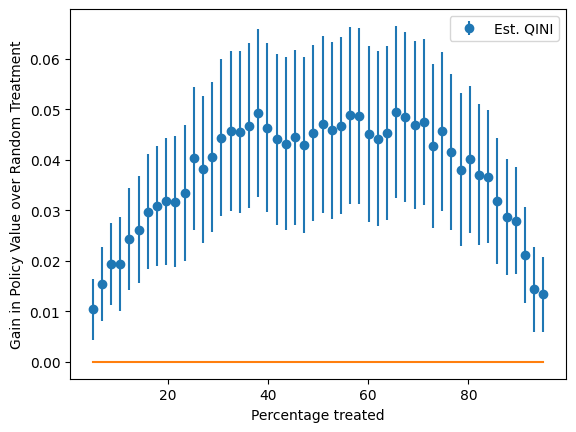

In [85]:
plt.errorbar(100 - ugrid, toc, yerr=1.96 * toc_std, fmt='o', label='Est. QINI')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True QINI')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Policy Value over Random Treatment")
plt.legend()
plt.savefig(f'{data}-qini.png', dpi=600)
plt.show()

And for uniform coverage we can again use a confidence band critical value

In [86]:
V = toc_psi @ toc_psi.T / toc_psi.shape[1]
sigmas = np.sqrt(np.diag(V))
V /= sigmas.reshape(-1, 1)
V /= sigmas.reshape(1, -1)

In [87]:
epsilon = np.random.multivariate_normal(np.zeros(V.shape[0]), V, size=(100000))
uniform_critical_value = np.percentile(np.max(np.abs(epsilon), axis=1), 95)
uniform_critical_value

2.9548419808815374

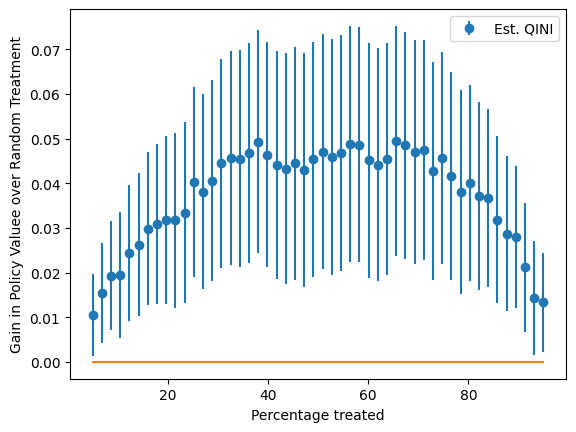

In [88]:
plt.errorbar(100 - ugrid, toc, yerr=uniform_critical_value * toc_std, fmt='o', label='Est. QINI')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True QINI')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Policy Valuee over Random Treatment")
plt.legend()
plt.savefig(f'{data}-qini-band.png', dpi=600)
plt.show()

Or the one-sided critical value

In [89]:
uniform_one_side_critical_value = np.percentile(np.max(np.abs(epsilon), axis=1), 90)
print(uniform_one_side_critical_value)

2.695409776579346


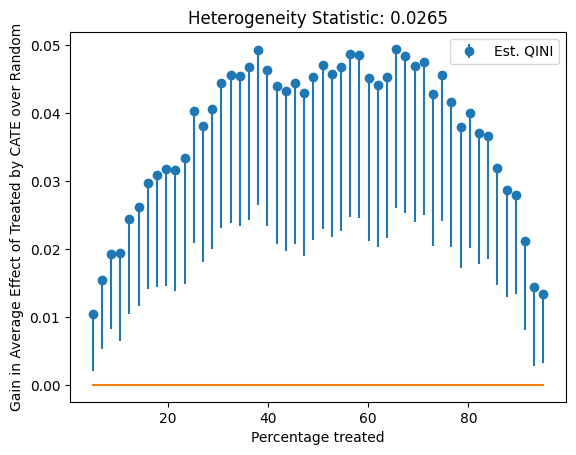

In [90]:
plt.errorbar(100 - ugrid, toc, yerr=[uniform_one_side_critical_value * toc_std, np.zeros(len(toc))],
             fmt='o', label='Est. QINI')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True QINI')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.title(f'Heterogeneity Statistic: {np.max(toc - uniform_one_side_critical_value*toc_std):.4f}')
plt.legend()
plt.savefig(f'{data}-qini-one-sided-band.png', dpi=600)
plt.show()

In [91]:
qini_psi = np.sum(toc_psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
qini = np.sum(toc[:-1] * np.diff(ugrid) / 100)
qini_stderr = np.sqrt(np.mean(qini_psi**2) / n)
print(f'QINI: {qini:.4f}, s.e.: {qini_stderr:.4f}, '
      f'One-Sided 95% CI=[{qini - scipy.stats.norm.ppf(.95) * qini_stderr:.4f}, Infty]')

QINI: 0.0342, s.e.: 0.0049, One-Sided 95% CI=[0.0262, Infty]


# Marginal Plots

In [92]:
important_feats = Z.columns[np.argsort(np.mean(shap_values.values**2, axis=0))[::-1]]
important_feats[:4]

Index(['polviews', 'partyid_6.0', 'educ', 'hrs1'], dtype='object')

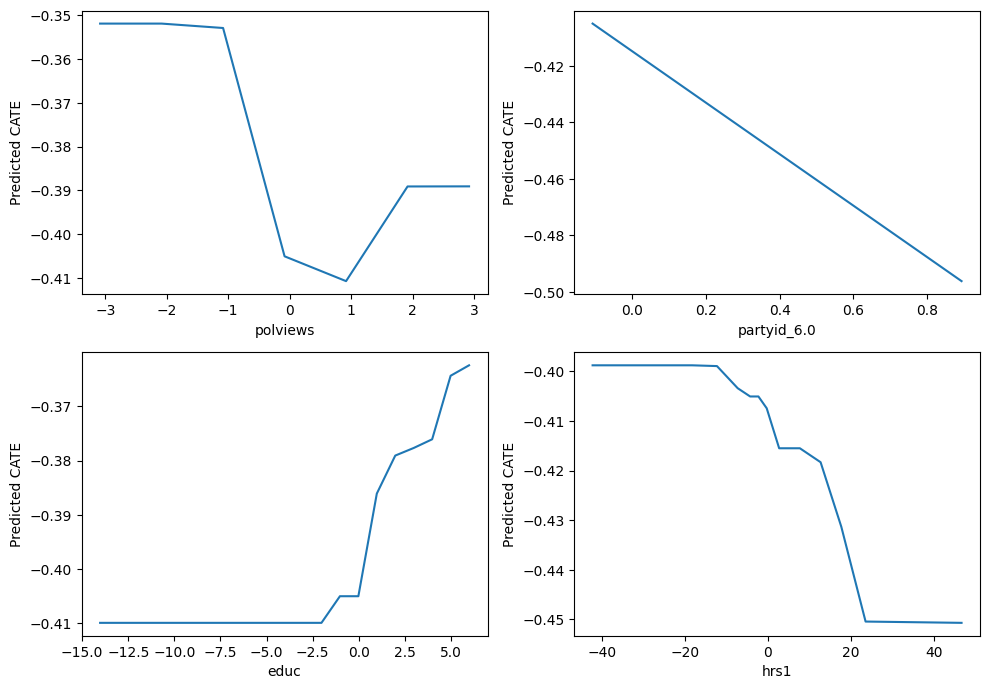

In [93]:
plt.figure(figsize=(10, 7))
for it, feature in enumerate(important_feats[:4]):
    plt.subplot(2, 2, it + 1)
    grid = np.unique(np.percentile(Z[feature], np.arange(0, 105, 5)))
    Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                       columns=Z.columns)
    Zpd[feature] = grid

    preds = overall_best.predict(Zpd)
    preds = preds.flatten()
    plt.errorbar(Zpd[feature], preds)
    plt.xlabel(feature)
    plt.ylabel('Predicted CATE')
plt.tight_layout()
plt.savefig(f'{data}-marginal-plots.png', dpi=600)
plt.show()

# Policy Learning

Suppose our goal is to estimate the best treatment policy $\pi: Z \to \{0, 1\}$. The policy gains over no treatment for any policy $\pi$ can be identified as:
\begin{align}
V(\pi) := E[\pi(Z)\, (Y(1) - Y(0))] = E\left[\pi(Z)\, Y^{DR}(g,p)\right]
\end{align}

Moreover, note that optimizing the linear objective $E[\pi(Z)\, Y^{DR}(g,p)]$ can also be written as a sample-weighted classification problem, where the goal of $\pi$ is to much the sign of $Y^{DR}(g,p)$, with sample weights $|Y^{DR}(g,p)|$.
\begin{align}
\text{argmin}_{\pi} V(\pi) =~& \text{argmin}_{\pi} E\left[(2\pi(Z) - 1)\, Y^{DR}(g,p)\right]\\
=~& \text{argmin}_{\pi} E\left[\left(2\pi(Z) - 1\right)\, \text{sign}\left(Y^{DR}(g,p)\right)\, \left|Y^{DR}(g,p)\right|\right] \\
=~& \text{argmin}_{\pi} E\left[1\left\{2\pi(Z) - 1 = \text{sign}\left(Y^{DR}(g,p)\right)\right\} \left|Y^{DR}(g,p)\right|\right]
\end{align}

In [94]:
policy = DecisionTreeClassifier(max_depth=2, min_impurity_decrease=1e-3,
                                min_samples_leaf=100,
                                random_state=random_seed)
policy.fit(Z, np.sign(dr_preds - treatment_cost), sample_weight=np.abs(dr_preds - treatment_cost))

DecisionTreeClassifier(max_depth=2, min_impurity_decrease=0.001,
                       min_samples_leaf=100, random_state=1)

We can also plot the tree to visualize the partitions and the treatment recommendations. The details that are displayed on each node are also useful in understanding the group average treatment effect for each node. In particular, the information `samples=N`, gives us the size of each node $N$, and the information `value=[A, B]`, then `A` is the sum of the $|Y^{DR}(g,p)|$ for the samples where $Y^{DR}(g,p)<0$ and similarly, `B` is the sum of $|Y^{DR}(g,p)|$ for the samples where $Y^{DR}(g,p)>0$. Thus to get the GATE for each node, we simply do `(B-A)/N`, which would correspond to $\frac{1}{N}\sum_{i\in \text{node}} Y^{DR}(g,p)$, which is the doubly robust estimate of the GATE for the node.

LM Adjustments - Changing Parameters

In [102]:
# Adjusted parameters for a more complex tree
policy2 = DecisionTreeClassifier(
    max_depth=5,  # Allow deeper trees to capture more complex patterns
    min_samples_split=10,  # Require at least 10 samples to split a node
    min_samples_leaf=50,  # Set a minimum of 50 samples per leaf node to prevent overfitting
    max_features='sqrt',  # Limit the number of features considered for each split
    criterion='entropy',  # Use information gain (entropy) instead of Gini index
    min_impurity_decrease=1e-3,  # Require a minimum impurity decrease for each split
    random_state=random_seed
)

# Fit the model with the adjusted parameters
policy2.fit(Z, np.sign(dr_preds - treatment_cost), sample_weight=np.abs(dr_preds - treatment_cost))

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='sqrt',
                       min_impurity_decrease=0.001, min_samples_leaf=50,
                       min_samples_split=10, random_state=1)

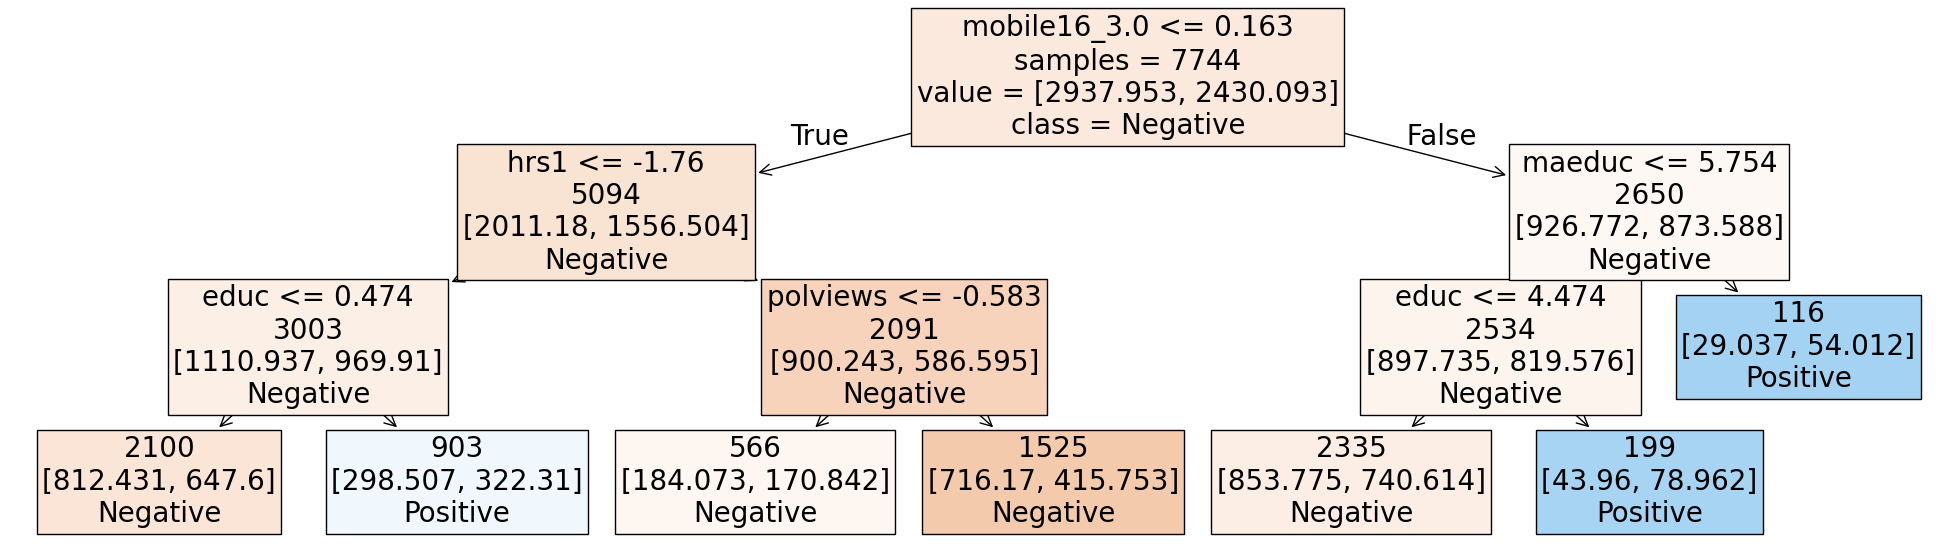

In [103]:
plt.figure(figsize=(25, 7))
plot_tree(policy2, filled=True, feature_names=list(Z.columns), impurity=False, label='root',
          class_names=['Negative', 'Positive'], fontsize=20)
plt.savefig(f'{data}-policy-tree.pdf', dpi=1200)
plt.show()

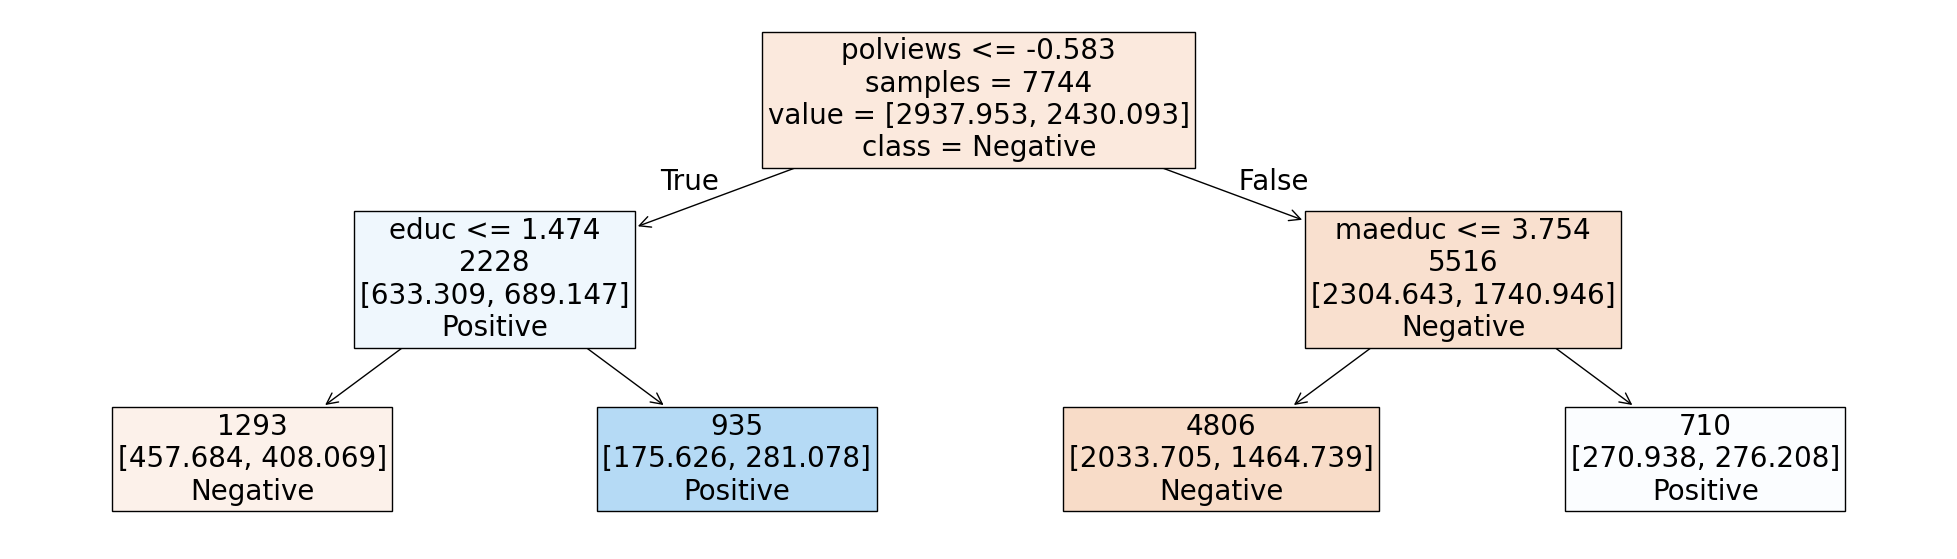

In [95]:
plt.figure(figsize=(25, 7))
plot_tree(policy, filled=True, feature_names=list(Z.columns), impurity=False, label='root',
          class_names=['Negative', 'Positive'], fontsize=20)
plt.savefig(f'{data}-policy-tree.pdf', dpi=1200)
plt.show()

#### Evaluating the learned policy out of sample

In [96]:
pi = (dr_val - treatment_cost) * policy.predict(Zval)
point = np.mean(pi)
stderr = np.sqrt(np.var(pi) / pi.shape[0])
print(f"{point:.5f}, {stderr:.5f}, {point - 1.96 * stderr:.5f}, {point + 1.96 * stderr:.5f}")

0.06366, 0.01473, 0.03479, 0.09252


#### As compared to treating everyone

In [97]:
pi = (dr_val - treatment_cost)
point = np.mean(pi)
stderr = np.sqrt(np.var(pi) / pi.shape[0])
print(f"{point:.5f}, {stderr:.5f}, {point - 1.96 * stderr:.5f}, {point + 1.96 * stderr:.5f}")

-0.06597, 0.01472, -0.09482, -0.03711
